In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
import pickle
import lightgbm as lgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit , RandomizedSearchCV
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from optuna.integration import lightgbm as lgb_tuner
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from prettytable import PrettyTable
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing

In [14]:
sales = pd.read_csv("D:/Case Study/Predict future sales/sales_train.csv")

items = pd.read_csv("D:/Case Study/Predict future sales/items.csv")

item_cat = pd.read_csv("D:/Case Study/Predict future sales/item_categories.csv")

test = pd.read_csv("D:/Case Study/Predict future sales/test.csv")

In [9]:
# Aranging columns 
train_monthly = train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly['revenue'] = train_monthly['item_price'] * train_monthly['item_cnt_day']

# Group by month in this case "date_block_num" and aggregate features.
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({ 'item_cnt_day':['sum', 'mean'],'item_price':['mean'], 'revenue':['sum']})

# Rename columns
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_cnt_month', 'mean_item_cnt', 'mean_item_price', 'revenue_month']

In [10]:
train_monthly.head()

,date_block_num,shop_id,item_category_id,item_id,item_cnt_month,mean_item_cnt,mean_item_price,revenue_month
0,0,2,2,5572,9.0,1.285714,1532.857143,13910.00
1,0,2,2,5573,2.0,1.000000,924.000000,1848.00
2,0,2,2,5575,4.0,1.000000,955.005000,3820.02
3,0,2,2,5576,3.0,1.000000,2490.000000,7470.00
4,0,2,2,5632,1.0,1.000000,2390.000000,2390.00


In [11]:
##### reduce the amount of data
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in tqdm(df.columns):
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

train_monthly = reduce_mem_usage(train_monthly)

  0%|          | 0/8 [00:00<?, ?it/s]

Memory usage after optimization is: 35.26 MB
Decreased by 68.1%


In [12]:
# Build a data set with all the possible combinations of ['date_block_num','shop_id','item_id'] so we won't have missing records.
shop_ids = test['shop_id'].unique()
item_ids = test['item_id'].unique()
all_posible = []
for i in tqdm(range(34)):
    for shop in shop_ids:
        for item in item_ids:
            all_posible.append([i, shop, item])
    
empty_df = pd.DataFrame(all_posible, columns=['date_block_num','shop_id','item_id'])

# Create a test set for month 34.
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

# Concatenate empty_df and test sets.
empty_df = pd.concat([empty_df, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=["date_block_num", "shop_id", "item_id"])
empty_df.fillna( 0, inplace = True )

  0%|          | 0/34 [00:00<?, ?it/s]

In [13]:
# Merge the train set with the complete set and fill missing records with 0
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)

# Add item category id again for test block 34
train_monthly = train_monthly.drop(['item_category_id'], axis=1).join(items, on='item_id', rsuffix='_').drop(['item_id_','item_name'], axis=1)

# Aranging columns 
train_monthly = train_monthly[['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'revenue_month', 'item_cnt_month', 'mean_item_cnt','mean_item_price']]

train_monthly['item_cnt_month'] = train_monthly['item_cnt_month'].fillna(0).clip(0, 20)

# Extract time based features (month)
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

# Add date_block_shop_mean
date_block_shop_mean = train_monthly.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
date_block_shop_mean.columns = ['date_block_shop_mean']
date_block_shop_mean.reset_index(inplace=True)
train_monthly = pd.merge(train_monthly, date_block_shop_mean, on=['date_block_num', 'shop_id'], how='left')

# Add date_block_item_mean
date_block_item_mean = train_monthly.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
date_block_item_mean.columns = ['date_block_item_mean']
date_block_item_mean.reset_index(inplace=True)
train_monthly = pd.merge(train_monthly, date_block_item_mean, on=['date_block_num', 'item_id'], how='left')

# Add date_category_mean
date_category_mean = train_monthly.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
date_category_mean.columns = ['date_cat_mean']
date_category_mean.reset_index(inplace=True)
train_monthly = pd.merge(train_monthly, date_category_mean, on=['date_block_num', 'item_category_id'], how='left')

train_monthly.fillna(0, inplace=True)
train_monthly = reduce_mem_usage(train_monthly)

  0%|          | 0/12 [00:00<?, ?it/s]

Memory usage after optimization is: 214.49 MB
Decreased by 53.1%


In [14]:
# Define function to compute lag features
def lag_feature( df,lags, cols ):
    for col in cols:
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        print(col)
        for i in tqdm(range(1,lags+1)):
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [15]:
# Add lag features 
train_monthly = lag_feature( train_monthly, 3 , ['item_cnt_month','revenue_month','mean_item_cnt','mean_item_price', 'date_block_shop_mean','date_block_item_mean','date_cat_mean'] )

# fill null values with zeros and optimize the memory 
train_monthly = train_monthly.fillna(0)
train_monthly = reduce_mem_usage(train_monthly)

item_cnt_month


  0%|          | 0/3 [00:00<?, ?it/s]

revenue_month


  0%|          | 0/3 [00:00<?, ?it/s]

mean_item_cnt


  0%|          | 0/3 [00:00<?, ?it/s]

mean_item_price


  0%|          | 0/3 [00:00<?, ?it/s]

date_block_shop_mean


  0%|          | 0/3 [00:00<?, ?it/s]

date_block_item_mean


  0%|          | 0/3 [00:00<?, ?it/s]

date_cat_mean


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

Memory usage after optimization is: 557.68 MB
Decreased by 0.0%


In [16]:
# Add quarter mean count
train_monthly['qmean_item_cnt'] = train_monthly[['item_cnt_month_lag_1', 
                                    'item_cnt_month_lag_2', 
                                    'item_cnt_month_lag_3']].mean(skipna=True, axis=1)
# Add quarter std count
train_monthly['qstd_item_cnt'] = train_monthly[['item_cnt_month_lag_1', 
                                    'item_cnt_month_lag_2', 
                                    'item_cnt_month_lag_3']].std(skipna=True, axis=1)
# Add quarter min count
train_monthly['qmin_item_cnt'] = train_monthly[['item_cnt_month_lag_1', 
                                    'item_cnt_month_lag_2', 
                                    'item_cnt_month_lag_3']].min(skipna=True, axis=1)
# Add quarter max count
train_monthly['qmax_item_cnt'] = train_monthly[['item_cnt_month_lag_1', 
                                    'item_cnt_month_lag_2', 
                                    'item_cnt_month_lag_3']].max(skipna=True, axis=1)

In [17]:
X = train_monthly.drop(['item_cnt_month','mean_item_price','revenue_month','mean_item_cnt', 'date_block_shop_mean','date_block_item_mean','date_cat_mean'], axis=1)
y = train_monthly['item_cnt_month']

#Normalize Dataset
scaler = MinMaxScaler()
for col in tqdm(X.columns[4:]):
    X[col] = scaler.fit_transform(X[col].values.reshape(-1,1))

# saving final preprosessed data into drive 
X = reduce_mem_usage(X)
with open('D:/Case Study/Predict future sales/preprocessed_set2','wb') as loc:
    pickle.dump((X,y),loc)

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Memory usage after optimization is: 464.73 MB
Decreased by 15.6%


# Train test split

In [2]:
# Load preprocessed data
with open('D:/Case Study/Predict future sales/preprocessed_set2','rb') as loc:
    X, y = pickle.load(loc)

In [3]:
# slpitting data into train,validation and test 
X_train = X[X['date_block_num']<33]
X_train = X_train[X['date_block_num']>2]
y_train = y[X['date_block_num']<33]
y_train = y_train[X['date_block_num']>2]

X_val = X[X['date_block_num']==33]
y_val = y[X['date_block_num']==33]

X_test = X[X['date_block_num']==34]

In [4]:
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape)

(6426000, 30) (214200, 30) (214200, 30)
(6426000,) (214200,)


# Machine Learning

## Lasso Regression

In [5]:
alpha = [10**i for i in range(-6,2)]


train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = Lasso(alpha= i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:/Case Study/Predict future sales/best_lasso','wb') as loc:
                pickle.dump(_model,loc)
    else:
        print("model saving.....")
        with open('D:/Case Study/Predict future sales/best_lasso','wb') as loc:
            pickle.dump(_model,loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-"*50)
    
with open('D:/Case Study/Predict future sales/lasso_log','wb') as loc:
    pickle.dump((train_score,val_score,alpha),loc)

  0%|          | 0/8 [00:00<?, ?it/s]

alpha = 1e-06 
model saving.....
Training Loss is 0.7768836617469788 
Validation Loss is 0.8960020542144775 
--------------------------------------------------
alpha = 1e-05 
Training Loss is 0.7771653532981873 
Validation Loss is 0.8962953686714172 
--------------------------------------------------
alpha = 0.0001 
Training Loss is 0.7779373526573181 
Validation Loss is 0.8962581753730774 
--------------------------------------------------
alpha = 0.001 
Training Loss is 0.7823495864868164 
Validation Loss is 0.9005433917045593 
--------------------------------------------------
alpha = 0.01 
Training Loss is 0.8255051970481873 
Validation Loss is 0.9233364462852478 
--------------------------------------------------
alpha = 0.1 
Training Loss is 1.0584886074066162 
Validation Loss is 1.0881119966506958 
--------------------------------------------------
alpha = 1 
Training Loss is 1.0613807439804077 
Validation Loss is 1.0924110412597656 
---------------------------------------------

In [ ]:
with open('D:/Case Study/Predict future sales/best_lasso','rb') as loc:
    best_lasso = pickle.load(loc)
with open('D:/Case Study/Predict future sales/lasso_log','rb') as loc:
    train_score,val_score,alpha=pickle.load(loc)

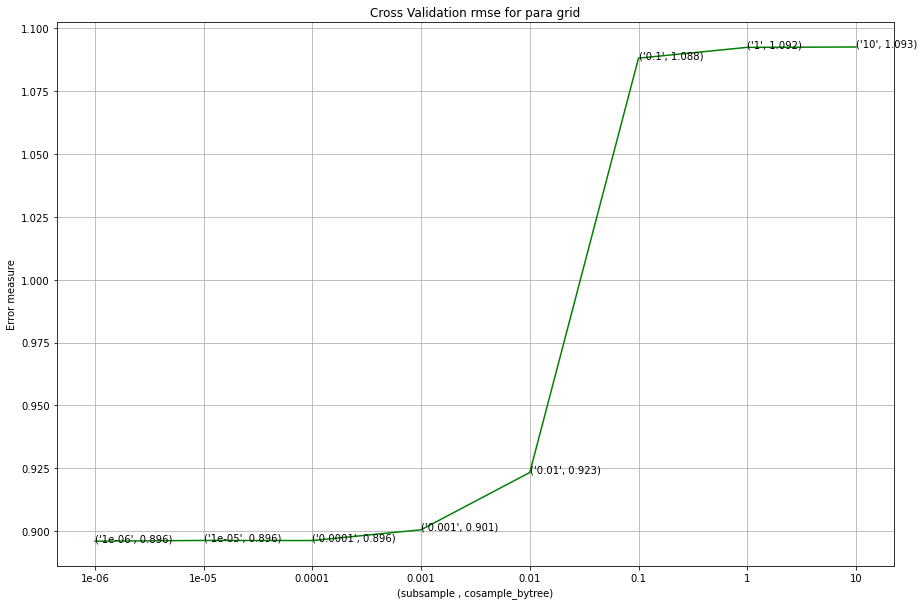

In [44]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

## Ridge Regression


In [36]:
alpha = [10**i for i in range(-10,2)]


train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = Ridge(alpha= i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:/Case Study/Predict future sales/best_ridge','wb') as loc:
                pickle.dump(_model,loc)
    else:
        print("model saving.....")
        with open('D:/Case Study/Predict future sales/best_ridge','wb') as loc:
            pickle.dump(_model,loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-"*50)
    
with open('D:/Case Study/Predict future sales/ridge_log','wb') as loc:
    pickle.dump((train_score,val_score,alpha),loc)

  0%|          | 0/12 [00:00<?, ?it/s]

alpha = 1e-10 
model saving.....
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959961533546448 
--------------------------------------------------
alpha = 1e-09 
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959961533546448 
--------------------------------------------------
alpha = 1e-08 
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959961533546448 
--------------------------------------------------
alpha = 1e-07 
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959961533546448 
--------------------------------------------------
alpha = 1e-06 
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959961533546448 
--------------------------------------------------
alpha = 1e-05 
Training Loss is 0.7768925428390503 
Validation Loss is 0.8959962725639343 
--------------------------------------------------
alpha = 0.0001 
Training Loss is 0.7768924832344055 
Validation Loss is 0.8959962725639343 
--------------------------------------

In [ ]:
with open('D:/Case Study/Predict future sales/best_ridge','rb') as loc:
    best_ridge = pickle.load(loc)
with open('D:/Case Study/Predict future sales/ridge_log','rb') as loc:
    train_score,val_score,alpha = pickle.load(loc)

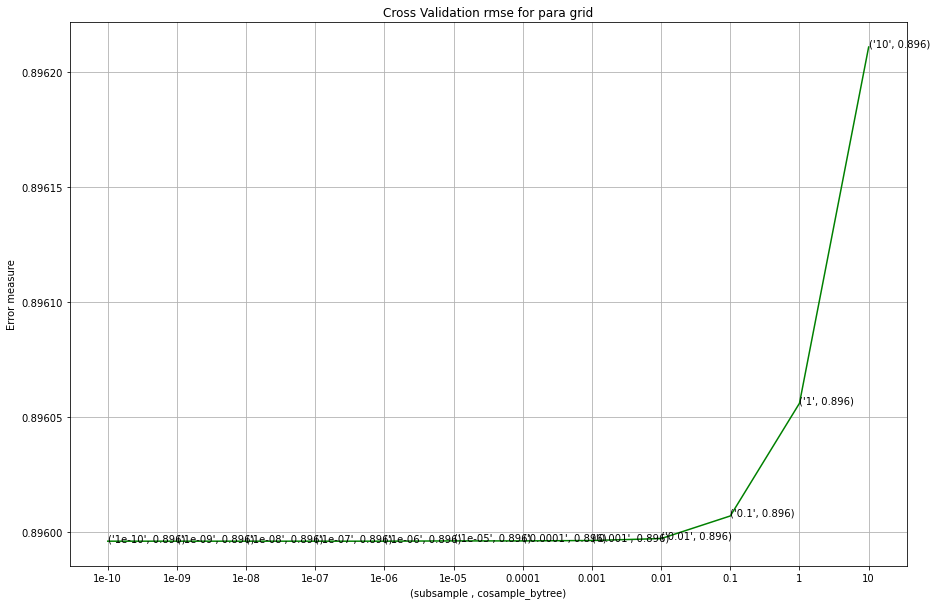

In [38]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

## Decision Tree Regressor


In [7]:
alpha = [3,5,7,9,12]


train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = DecisionTreeRegressor(max_depth = i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:/Case Study/Predict future sales/best_dt','wb') as loc:
                pickle.dump(_model,loc)
    else:
        print("model saving.....")
        with open('D:/Case Study/Predict future sales/best_dt','wb') as loc:
            pickle.dump(_model,loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-"*50)
    
with open('D:/Case Study/Predict future sales/dt_log','wb') as loc:
    pickle.dump((train_score,val_score,alpha),loc)

  0%|          | 0/5 [00:00<?, ?it/s]

alpha = 3 
model saving.....
Training Loss is 0.8036969091426813 
Validation Loss is 0.92170921301671 
--------------------------------------------------
alpha = 5 
model saving.....
Training Loss is 0.7804948263500386 
Validation Loss is 0.9035761655190938 
--------------------------------------------------
alpha = 7 
Training Loss is 0.7641830314861898 
Validation Loss is 0.906097961374619 
--------------------------------------------------
alpha = 9 
model saving.....
Training Loss is 0.7448521301630756 
Validation Loss is 0.900079579184458 
--------------------------------------------------
alpha = 12 
Training Loss is 0.698659872401712 
Validation Loss is 0.9310469176485541 
--------------------------------------------------


In [ ]:
with open('D:/Case Study/Predict future sales/best_dt','rb') as loc:
    best_dt = pickle.load(loc)
with open('D:/Case Study/Predict future sales/dt_log','rb') as loc:
    train_score,val_score,alpha = pickle.load(loc)

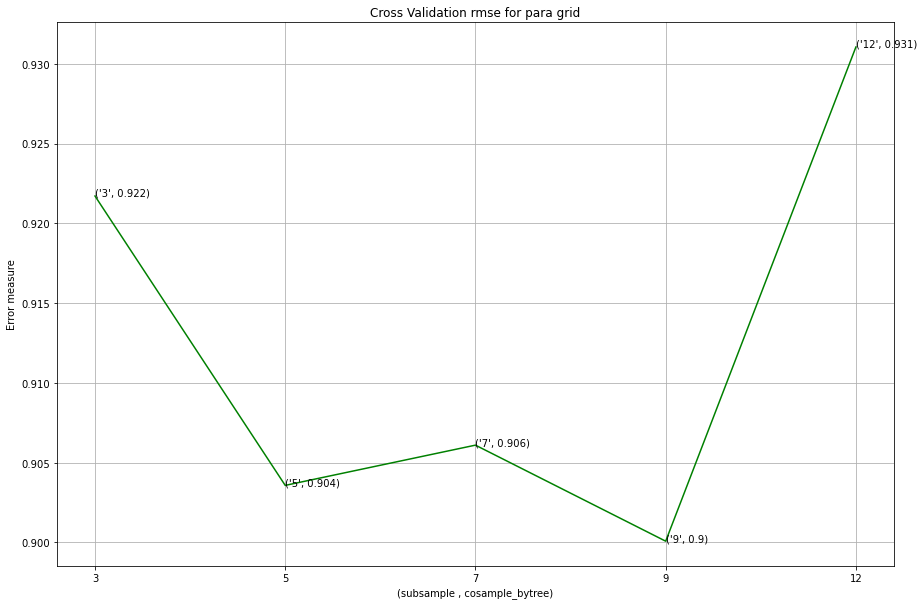

In [32]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

<AxesSubplot:>

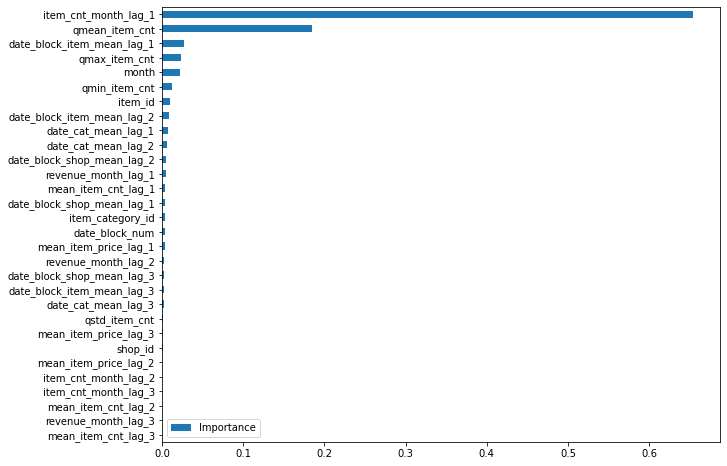

In [33]:
feat_importances = pd.DataFrame(best_dt.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot.barh(figsize=(10,8))

## Random Forest Regressor


In [6]:
alpha = [3,5,7,9]


train_score = []
val_score = []
for i in tqdm(alpha):
    
    print("alpha = {} ".format(i))
    _model = RandomForestRegressor(max_depth = i)
    _model.fit(X_train, y_train)
    rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
    rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

    if val_score:
        if sorted(val_score)[0] > rmse_val:
            print("model saving.....")
            with open('D:/Case Study/Predict future sales/best_rf','wb') as loc:
                pickle.dump(_model,loc)
    else:
        print("model saving.....")
        with open('D:/Case Study/Predict future sales/best_rf','wb') as loc:
            pickle.dump(_model,loc)

    train_score.append(rmse_train)
    val_score.append(rmse_val)
    print("Training Loss is {} ".format(rmse_train))
    print("Validation Loss is {} ".format(rmse_val))
    print("-"*50)
    
with open('D:/Case Study/Predict future sales/rf_log','wb') as loc:
    pickle.dump((train_score,val_score,alpha),loc)

  0%|          | 0/4 [00:00<?, ?it/s]

alpha = 3 
model saving.....
Training Loss is 0.7978943859457616 
Validation Loss is 0.9168346321939186 
--------------------------------------------------
alpha = 5 
model saving.....
Training Loss is 0.7751766605844664 
Validation Loss is 0.9034780140710251 
--------------------------------------------------
alpha = 7 
model saving.....
Training Loss is 0.757220023222289 
Validation Loss is 0.893994221201527 
--------------------------------------------------
alpha = 9 
model saving.....
Training Loss is 0.7329095785490138 
Validation Loss is 0.8875476785639311 
--------------------------------------------------


In [ ]:
with open('D:/Case Study/Predict future sales/best_rf','rb') as loc:
    best_rf = pickle.load(loc)  
with open('D:/Case Study/Predict future sales/rf_log','rb') as loc:
    train_score,val_score,alpha = pickle.load(loc)

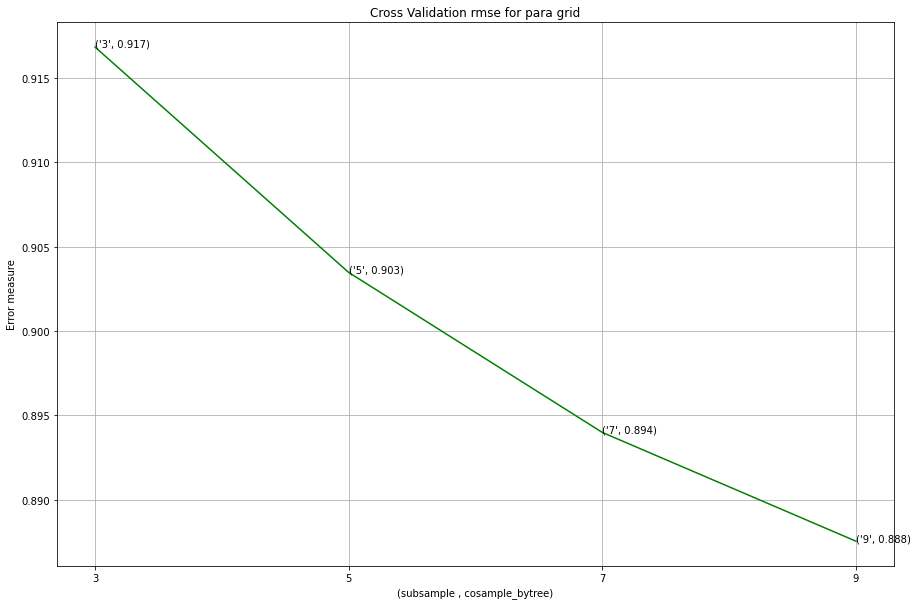

In [8]:
params = [str(i) for i in alpha]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

<AxesSubplot:>

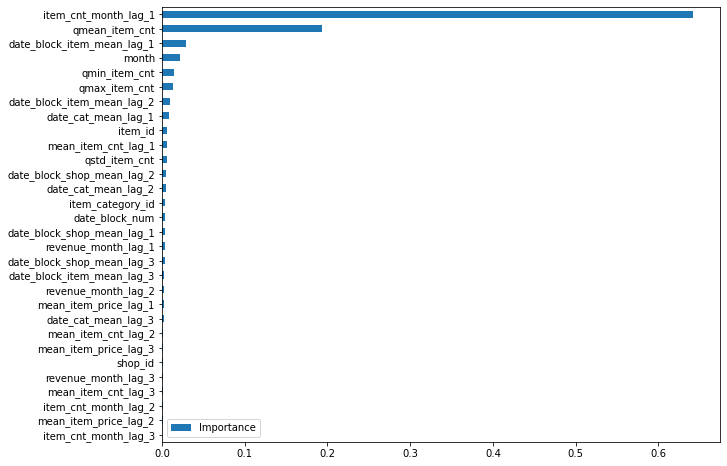

In [30]:
feat_importances = pd.DataFrame(best_rf.feature_importances_, index=X.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=True, inplace=True)
feat_importances.plot.barh(figsize=(10,8))

## XGBoost Regressor 

### Custom Grid search Part 1

In [46]:
max_depth = [4, 6, 8, 10, 12]
min_child_weight = [1, 10, 100]

fit_params={"early_stopping_rounds":20, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_val, y_val]] }

train_score = []
val_score = []
params = []
for i in max_depth:
    for j in min_child_weight:
        print("Tuning parameter subsamle and cosample_bytree")
        print("set subsamle = {} and cosample_bytree = {}".format(i,j))
        _model = XGBRegressor(eta = 0.1, n_estimators=1000,max_depth=i ,min_child_weight=j, verbose=100)
        _model.fit(X_train, y_train, verbose=True, **fit_params)
        rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
        rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

        if val_score:
            if sorted(val_score)[0] > rmse_val:
                print("model saving.....")
                with open('D:/Case Study/Predict future sales/best_xgb_1','wb') as loc:
                    pickle.dump(_model,loc)
        else:
            print("model saving.....")
            with open('D:/Case Study/Predict future sales/best_xgb_1','wb') as loc:
                pickle.dump(_model,loc)

        train_score.append(rmse_train)
        val_score.append(rmse_val)
        params.append((i,j))

        print("Training Loss when max_depth={} and min_child_weight={} is {} ".format(i,j,rmse_train))
        print("Validation Loss when max_depth={} and min_child_weight={} is {} ".format(i,j,rmse_val))
        print("-"*50)
        
with open('D:/Case Study/Predict future sales/xgb_log_1','wb') as loc:
    pickle.dump((train_score,val_score,params),loc)

Tuning parameter subsamle and cosample_bytree
set subsamle = 4 and cosample_bytree = 1
[15:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.07571
[1]	validation_0-rmse:1.04007
[2]	validation_0-rmse:1.01114
[3]	validation_0-rmse:0.98782
[4]	validation_0-rmse:0.96884
[5]	validation_0-rmse:0.95262
[6]	validation_0-rmse:0.94028
[7]	validation_0-rmse:0.93002
[8]	validation_0-rmse:0.92158
[9]	validation_0-rmse:0.91536
[10]	validation_0-rmse:0.90968
[11]	validation_0-rmse:0.90509
[12]	validation_0-rmse:0.90134
[13]	validation_0-rmse:0.89916
[14]	validation_0-rmse:0.89665
[15]	validation_0-rmse:0.89502
[16]	validation_0-rmse:0.89384
[17]	vali

[245]	validation_0-rmse:0.87392
[246]	validation_0-rmse:0.87394
[247]	validation_0-rmse:0.87396
[248]	validation_0-rmse:0.87389
[249]	validation_0-rmse:0.87390
[250]	validation_0-rmse:0.87376
[251]	validation_0-rmse:0.87372
[252]	validation_0-rmse:0.87373
[253]	validation_0-rmse:0.87356
[254]	validation_0-rmse:0.87355
[255]	validation_0-rmse:0.87338
[256]	validation_0-rmse:0.87305
[257]	validation_0-rmse:0.87285
[258]	validation_0-rmse:0.87299
[259]	validation_0-rmse:0.87300
[260]	validation_0-rmse:0.87296
[261]	validation_0-rmse:0.87296
[262]	validation_0-rmse:0.87288
[263]	validation_0-rmse:0.87291
[264]	validation_0-rmse:0.87276
[265]	validation_0-rmse:0.87276
[266]	validation_0-rmse:0.87302
[267]	validation_0-rmse:0.87301
[268]	validation_0-rmse:0.87318
[269]	validation_0-rmse:0.87312
[270]	validation_0-rmse:0.87305
[271]	validation_0-rmse:0.87370
[272]	validation_0-rmse:0.87364
[273]	validation_0-rmse:0.87372
[274]	validation_0-rmse:0.87354
[275]	validation_0-rmse:0.87349
[276]	va

[198]	validation_0-rmse:0.87377
[199]	validation_0-rmse:0.87375
[200]	validation_0-rmse:0.87368
[201]	validation_0-rmse:0.87363
[202]	validation_0-rmse:0.87355
[203]	validation_0-rmse:0.87356
[204]	validation_0-rmse:0.87355
[205]	validation_0-rmse:0.87344
[206]	validation_0-rmse:0.87348
[207]	validation_0-rmse:0.87354
[208]	validation_0-rmse:0.87348
[209]	validation_0-rmse:0.87342
[210]	validation_0-rmse:0.87341
[211]	validation_0-rmse:0.87330
[212]	validation_0-rmse:0.87342
[213]	validation_0-rmse:0.87338
[214]	validation_0-rmse:0.87339
[215]	validation_0-rmse:0.87355
[216]	validation_0-rmse:0.87343
[217]	validation_0-rmse:0.87349
[218]	validation_0-rmse:0.87353
[219]	validation_0-rmse:0.87349
[220]	validation_0-rmse:0.87346
[221]	validation_0-rmse:0.87342
[222]	validation_0-rmse:0.87341
[223]	validation_0-rmse:0.87338
[224]	validation_0-rmse:0.87336
[225]	validation_0-rmse:0.87326
[226]	validation_0-rmse:0.87331
[227]	validation_0-rmse:0.87332
[228]	validation_0-rmse:0.87336
[229]	va

[163]	validation_0-rmse:0.87799
[164]	validation_0-rmse:0.87798
[165]	validation_0-rmse:0.87794
[166]	validation_0-rmse:0.87800
[167]	validation_0-rmse:0.87799
[168]	validation_0-rmse:0.87801
[169]	validation_0-rmse:0.87796
[170]	validation_0-rmse:0.87802
[171]	validation_0-rmse:0.87802
[172]	validation_0-rmse:0.87774
[173]	validation_0-rmse:0.87782
[174]	validation_0-rmse:0.87755
[175]	validation_0-rmse:0.87767
[176]	validation_0-rmse:0.87743
[177]	validation_0-rmse:0.87745
[178]	validation_0-rmse:0.87742
[179]	validation_0-rmse:0.87728
[180]	validation_0-rmse:0.87725
[181]	validation_0-rmse:0.87736
[182]	validation_0-rmse:0.87735
[183]	validation_0-rmse:0.87735
[184]	validation_0-rmse:0.87732
[185]	validation_0-rmse:0.87726
[186]	validation_0-rmse:0.87731
[187]	validation_0-rmse:0.87708
[188]	validation_0-rmse:0.87706
[189]	validation_0-rmse:0.87694
[190]	validation_0-rmse:0.87684
[191]	validation_0-rmse:0.87680
[192]	validation_0-rmse:0.87681
[193]	validation_0-rmse:0.87678
[194]	va

[66]	validation_0-rmse:0.87571
[67]	validation_0-rmse:0.87553
[68]	validation_0-rmse:0.87557
[69]	validation_0-rmse:0.87732
[70]	validation_0-rmse:0.87746
[71]	validation_0-rmse:0.87741
[72]	validation_0-rmse:0.87727
[73]	validation_0-rmse:0.87731
[74]	validation_0-rmse:0.87705
[75]	validation_0-rmse:0.87712
[76]	validation_0-rmse:0.87685
[77]	validation_0-rmse:0.87678
[78]	validation_0-rmse:0.87671
[79]	validation_0-rmse:0.87670
[80]	validation_0-rmse:0.87654
[81]	validation_0-rmse:0.87648
[82]	validation_0-rmse:0.87640
[83]	validation_0-rmse:0.87641
[84]	validation_0-rmse:0.87625
[85]	validation_0-rmse:0.87620
[86]	validation_0-rmse:0.87619
[87]	validation_0-rmse:0.87613
Training Loss when max_depth=6 and min_child_weight=10 is 0.7279612421989441 
Validation Loss when max_depth=6 and min_child_weight=10 is 0.8755369186401367 
--------------------------------------------------
Tuning parameter subsamle and cosample_bytree
set subsamle = 6 and cosample_bytree = 100
[17:18:29] WARNING: 

[17:45:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.07231
[1]	validation_0-rmse:1.03551
[2]	validation_0-rmse:1.00453
[3]	validation_0-rmse:0.97940
[4]	validation_0-rmse:0.95875
[5]	validation_0-rmse:0.94212
[6]	validation_0-rmse:0.92846
[7]	validation_0-rmse:0.91681
[8]	validation_0-rmse:0.90801
[9]	validation_0-rmse:0.90086
[10]	validation_0-rmse:0.89465
[11]	validation_0-rmse:0.89010
[12]	validation_0-rmse:0.88662
[13]	validation_0-rmse:0.88383
[14]	validation_0-rmse:0.88158
[15]	validation_0-rmse:0.87960
[16]	validation_0-rmse:0.87848
[17]	validation_0-rmse:0.87770
[18]	validation_0-rmse:0.87651
[19]	validation_0-rmse:0.87588
[20

[0]	validation_0-rmse:1.07249
[1]	validation_0-rmse:1.03519
[2]	validation_0-rmse:1.00450
[3]	validation_0-rmse:0.97863
[4]	validation_0-rmse:0.95807
[5]	validation_0-rmse:0.94125
[6]	validation_0-rmse:0.92738
[7]	validation_0-rmse:0.91611
[8]	validation_0-rmse:0.90772
[9]	validation_0-rmse:0.90062
[10]	validation_0-rmse:0.89541
[11]	validation_0-rmse:0.89003
[12]	validation_0-rmse:0.88655
[13]	validation_0-rmse:0.88336
[14]	validation_0-rmse:0.88120
[15]	validation_0-rmse:0.88003
[16]	validation_0-rmse:0.87863
[17]	validation_0-rmse:0.87738
[18]	validation_0-rmse:0.87627
[19]	validation_0-rmse:0.87477
[20]	validation_0-rmse:0.87450
[21]	validation_0-rmse:0.87437
[22]	validation_0-rmse:0.87403
[23]	validation_0-rmse:0.87344
[24]	validation_0-rmse:0.87384
[25]	validation_0-rmse:0.87406
[26]	validation_0-rmse:0.87387
[27]	validation_0-rmse:0.87413
[28]	validation_0-rmse:0.87403
[29]	validation_0-rmse:0.87376
[30]	validation_0-rmse:0.87340
[31]	validation_0-rmse:0.87367
[32]	validation_0-

In [9]:
with open('D:/Case Study/Predict future sales/xgb_log_1','rb') as loc:
    train_score,val_score,params = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_xgb_1','rb') as loc:
    best_xgb_1 = pickle.load(loc)

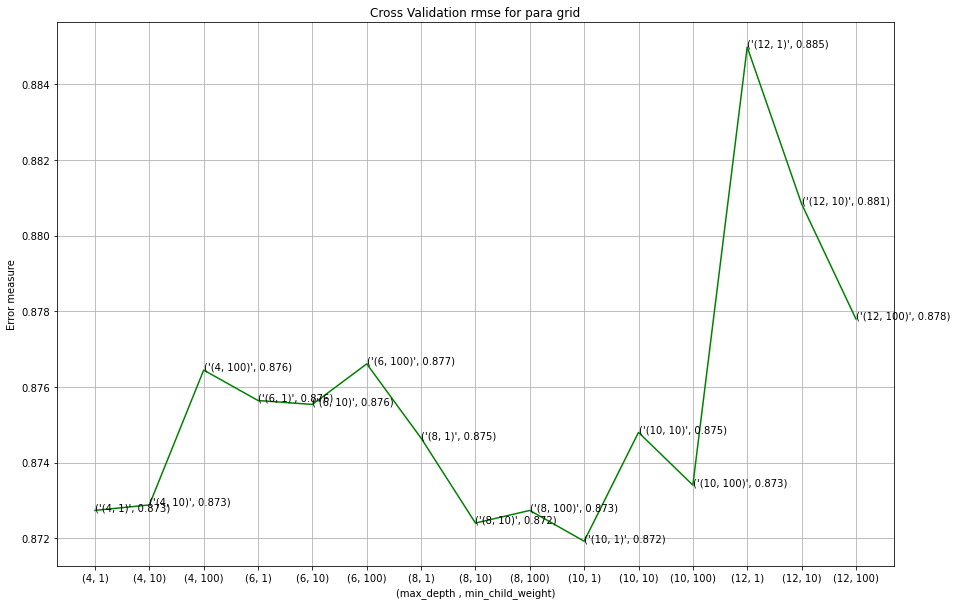

In [6]:
params = [str(i) for i in params]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score,c='g')
for i, txt in enumerate(np.round(val_score,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(max_depth , min_child_weight)")
plt.ylabel("Error measure")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

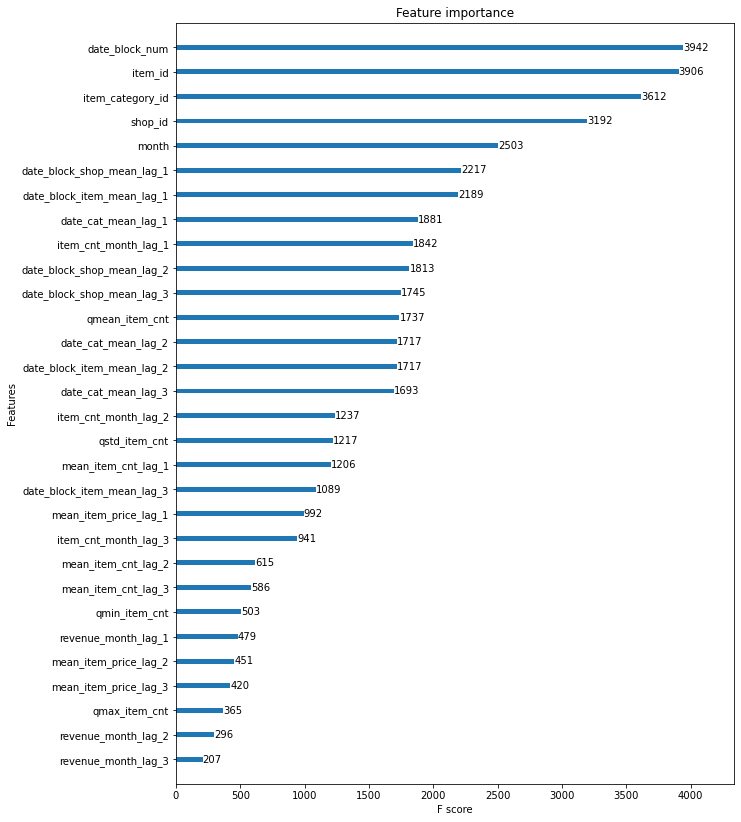

In [7]:
# Plot feature importance
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, grid=False)
plot_features(best_xgb_1, (10,14))

### Custom Grid search Part 2

In [10]:
subsample = [0.6,0.7,0.8,0.9]
cosample_bytree = [0.6,0.7,0.8,0.9]
fit_params={"early_stopping_rounds":10, 
            "eval_metric" : "rmse", 
            "eval_set" : [[X_val, y_val]] }

best_param_1 = params[np.argmin(val_score)]

train_score_2 = []
val_score_2 = []
params_2 = []
for i in subsample:
    for j in cosample_bytree:
        print("Tuning parameter subsamle and cosample_bytree")
        print("set max_depth = {} and min_child_weight = {}".format(best_param_1[0],best_param_1[1]))
        print("set subsamle = {} and cosample_bytree = {}".format(i,j))
        _model = XGBRegressor(eta = 0.1, n_estimators=1000,max_depth=best_param_1[0] ,min_child_weight=best_param_1[1],subsample=i,cosample_bytree=j)
        _model.fit(X_train, y_train, verbose=True, **fit_params)
        rmse_train = mean_squared_error(_model.predict(X_train).clip(0,20),y_train, squared=False)
        rmse_val = mean_squared_error(_model.predict(X_val).clip(0,20),y_val, squared=False)

        if val_score_2:
            if sorted(val_score_2)[0] > rmse_val:
                print("saving model.....")
                with open('D:/Case Study/Predict future sales/best_xgb_2','wb') as loc:
                    pickle.dump(_model,loc)
        else:
            print("saving model.....")
            with open('D:/Case Study/Predict future sales/best_xgb_2','wb') as loc:
                pickle.dump(_model,loc)

        train_score_2.append(rmse_train)
        val_score_2.append(rmse_val)
        params_2.append((i,j))

        print("Training Loss when subsample={} and cosample_bytree={} is {} ".format(i,j,rmse_train))
        print("Validation Loss when subsample={} and cosample_bytree={} is {} ".format(i,j,rmse_val))
        print("-"*50)

with open('D:/Case Study/Predict future sales/xgb_log_2','wb') as loc:
    pickle.dump((train_score_2,val_score_2,params_2),loc)

Tuning parameter subsamle and cosample_bytree
set max_depth = 10 and min_child_weight = 1
set subsamle = 0.6 and cosample_bytree = 0.6
[23:06:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cosample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.07255
[1]	validation_0-rmse:1.03521
[2]	validation_0-rmse:1.00482
[3]	validation_0-rmse:0.97908
[4]	validation_0-rmse:0.95777
[5]	validation_0-rmse:0.93986
[6]	validation_0-rmse:0.92668
[7]	validation_0-rmse:0.91568
[8]	validation_0-rmse:0.90799
[9]	validation_0-rmse:0.90137
[10]	validation_0-rmse:0.89540
[11]	validation_0-rmse:0.89166
[12]	validation_0-rmse:0.88804
[13]	validation_0-rmse:0.88564
[14]	validation_0-rmse:0.88400
[15]	validation

[14]	validation_0-rmse:0.88380
[15]	validation_0-rmse:0.88173
[16]	validation_0-rmse:0.88072
[17]	validation_0-rmse:0.88127
[18]	validation_0-rmse:0.88097
[19]	validation_0-rmse:0.88027
[20]	validation_0-rmse:0.87983
[21]	validation_0-rmse:0.87963
[22]	validation_0-rmse:0.87957
[23]	validation_0-rmse:0.87941
[24]	validation_0-rmse:0.87987
[25]	validation_0-rmse:0.87985
[26]	validation_0-rmse:0.87999
[27]	validation_0-rmse:0.88018
[28]	validation_0-rmse:0.87978
[29]	validation_0-rmse:0.88026
[30]	validation_0-rmse:0.87983
[31]	validation_0-rmse:0.87980
[32]	validation_0-rmse:0.87990
Training Loss when subsample=0.7 and cosample_bytree=0.6 is 0.7035846710205078 
Validation Loss when subsample=0.7 and cosample_bytree=0.6 is 0.8794052004814148 
--------------------------------------------------
Tuning parameter subsamle and cosample_bytree
set max_depth = 10 and min_child_weight = 1
set subsamle = 0.7 and cosample_bytree = 0.7
[23:54:14] WARNING: C:/Users/Administrator/workspace/xgboost-wi

[0]	validation_0-rmse:1.07325
[1]	validation_0-rmse:1.03670
[2]	validation_0-rmse:1.00608
[3]	validation_0-rmse:0.97992
[4]	validation_0-rmse:0.95901
[5]	validation_0-rmse:0.94203
[6]	validation_0-rmse:0.92803
[7]	validation_0-rmse:0.91685
[8]	validation_0-rmse:0.90822
[9]	validation_0-rmse:0.90119
[10]	validation_0-rmse:0.89504
[11]	validation_0-rmse:0.89036
[12]	validation_0-rmse:0.88737
[13]	validation_0-rmse:0.88392
[14]	validation_0-rmse:0.88200
[15]	validation_0-rmse:0.88101
[16]	validation_0-rmse:0.87993
[17]	validation_0-rmse:0.87838
[18]	validation_0-rmse:0.87875
[19]	validation_0-rmse:0.87848
[20]	validation_0-rmse:0.87836
[21]	validation_0-rmse:0.87798
[22]	validation_0-rmse:0.87763
[23]	validation_0-rmse:0.87794
[24]	validation_0-rmse:0.87781
[25]	validation_0-rmse:0.87734
[26]	validation_0-rmse:0.87750
[27]	validation_0-rmse:0.87749
[28]	validation_0-rmse:0.87758
[29]	validation_0-rmse:0.87758
[30]	validation_0-rmse:0.87784
[31]	validation_0-rmse:0.87817
[32]	validation_0-

[29]	validation_0-rmse:0.87441
[30]	validation_0-rmse:0.87412
[31]	validation_0-rmse:0.87387
[32]	validation_0-rmse:0.87344
Training Loss when subsample=0.9 and cosample_bytree=0.7 is 0.7024753093719482 
Validation Loss when subsample=0.9 and cosample_bytree=0.7 is 0.8728467226028442 
--------------------------------------------------
Tuning parameter subsamle and cosample_bytree
set max_depth = 10 and min_child_weight = 1
set subsamle = 0.9 and cosample_bytree = 0.8
[01:36:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cosample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-rmse:1.07289
[1]	validation_0-rmse:1.03590
[2]	validation_0-rmse:1.00451
[3]	validation_0-rmse:0.97843
[4]	validatio

In [11]:
with open('D:/Case Study/Predict future sales/xgb_log_2','rb') as loc:
    train_score_2,val_score_2,params_2 = pickle.load(loc)
    
with open('D:/Case Study/Predict future sales/best_xgb_1','rb') as loc:
    best_xgb_2 = pickle.load(loc)

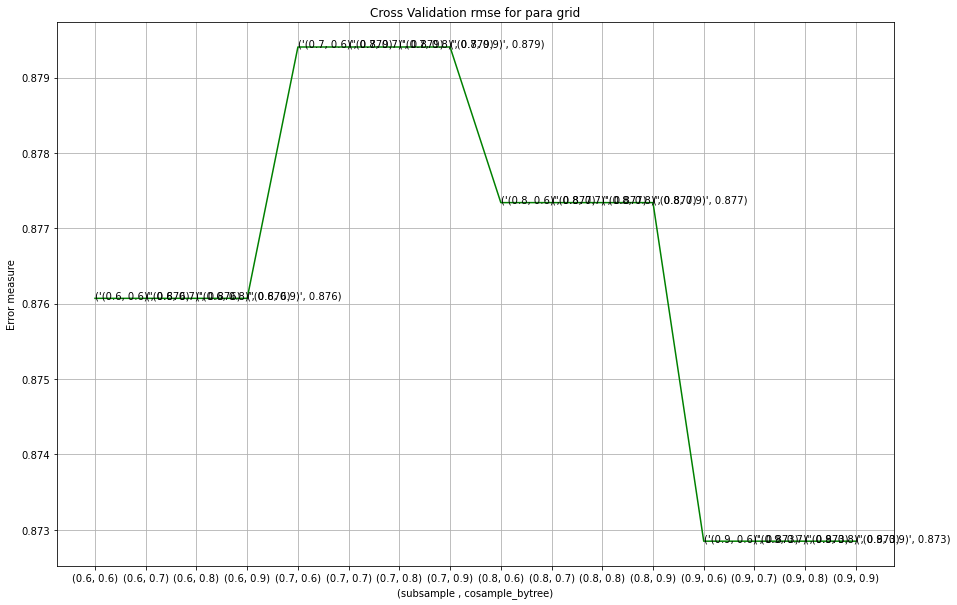

In [12]:
params = [str(i) for i in params_2]
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(params, val_score_2,c='g')
for i, txt in enumerate(np.round(val_score_2,3)):
    ax.annotate((params[i],np.round(txt,3)), (params[i],val_score_2[i]))
plt.grid()
plt.title("Cross Validation rmse for para grid")
plt.xlabel("(subsample , cosample_bytree)")
plt.ylabel("Error measure")
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

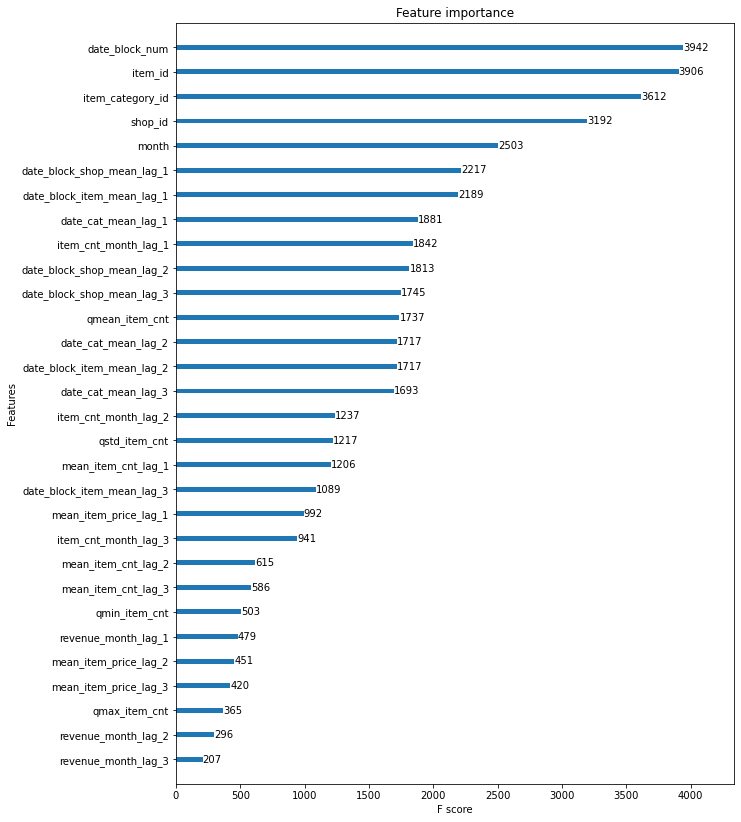

In [13]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax, grid=False)
plot_features(best_xgb_2, (10,14))

## LightGBM 

In [20]:
params = {
    'metric': 'rmse',
    'seed': 1,
    'verbose': 1,
    'force_row_wise' : True }

cat_feature_names = ['item_category_id, month', 'shop_id']

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=None)
lgb_eval  = lgb.Dataset(X_val, y_val, categorical_feature=None, reference=lgb_train)

gbm = lgb_tuner.train(
        params, 
        lgb_train,
        num_boost_round = 1000,
        valid_sets = (lgb_train, lgb_eval), 
        categorical_feature = cat_feature_names,
        verbose_eval = 10, 
        early_stopping_rounds = 100)

with open('D:/Case Study/Predict future sales/lgb_grid_2b','wb') as loc:
    pickle.dump(gbm,loc) 

[I 2022-04-01 05:05:22,572] A new study created in memory with name: no-name-0daa7e96-bc8e-4dfa-87e6-d02c38edc6c1
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.80937	valid_1's rmse: 0.902969
[20]	valid_0's rmse: 0.756109	valid_1's rmse: 0.875001
[30]	valid_0's rmse: 0.740908	valid_1's rmse: 0.870708
[40]	valid_0's rmse: 0.732969	valid_1's rmse: 0.869996
[50]	valid_0's rmse: 0.728184	valid_1's rmse: 0.870147
[60]	valid_0's rmse: 0.724305	valid_1's rmse: 0.870159
[70]	valid_0's rmse: 0.72109	valid_1's rmse: 0.870797
[80]	valid_0's rmse: 0.71684	valid_1's rmse: 0.868502
[90]	valid_0's rmse: 0.712864	valid_1's rmse: 0.874086
[100]	valid_0's rmse: 0.709553	valid_1's rmse: 0.87378
[110]	valid_0's rmse: 0.706755	valid_1's rmse: 0.873476
[120]	valid_0's rmse: 0.703785	valid_1's rmse: 0.878912
[130]	valid_0's rmse: 0.700046	valid_1's rmse: 0.882804
[140]	valid_0's rmse: 0.698332	valid_1's 

feature_fraction, val_score: 0.868239:  14%|######4                                      | 1/7 [00:55<05:31, 55.23s/it]

Early stopping, best iteration is:
[82]	valid_0's rmse: 0.7164	valid_1's rmse: 0.868239
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.806635	valid_1's rmse: 0.902125
[20]	valid_0's rmse: 0.75432	valid_1's rmse: 0.875319
[30]	valid_0's rmse: 0.739007	valid_1's rmse: 0.871265
[40]	valid_0's rmse: 0.730715	valid_1's rmse: 0.869297
[50]	valid_0's rmse: 0.725371	valid_1's rmse: 0.867856
[60]	valid_0's rmse: 0.721085	valid_1's rmse: 0.866736
[70]	valid_0's rmse: 0.716259	valid_1's rmse: 0.871927
[80]	valid_0's rmse: 0.713385	valid_1's rmse: 0.872279
[90]	valid_0's rmse: 0.709083	valid_1's rmse: 0.872083
[100]	valid_0's rmse: 0.706879	valid_1's rmse: 0.872204
[110]	valid_0's rmse: 0.704568	valid_1's rmse: 0.873111
[120]	valid_0's rmse: 0.701776	valid_1's rmse: 0.873164
[130]	

feature_fraction, val_score: 0.866407:  29%|############8                                | 2/7 [01:39<04:03, 48.76s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 0.719056	valid_1's rmse: 0.866407
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.81241	valid_1's rmse: 0.905051
[20]	valid_0's rmse: 0.760238	valid_1's rmse: 0.879697
[30]	valid_0's rmse: 0.744493	valid_1's rmse: 0.874351
[40]	valid_0's rmse: 0.736622	valid_1's rmse: 0.872827
[50]	valid_0's rmse: 0.732334	valid_1's rmse: 0.870955
[60]	valid_0's rmse: 0.728459	valid_1's rmse: 0.871305
[70]	valid_0's rmse: 0.725498	valid_1's rmse: 0.870997
[80]	valid_0's rmse: 0.722489	valid_1's rmse: 0.86991
[90]	valid_0's rmse: 0.719222	valid_1's rmse: 0.870199
[100]	valid_0's rmse: 0.7165	valid_1's rmse: 0.869715
[110]	valid_0's rmse: 0.71421	valid_1's rmse: 0.86936
[120]	valid_0's rmse: 0.711686	valid_1's rmse: 0.870933
[130]	val

feature_fraction, val_score: 0.866407:  43%|###################2                         | 3/7 [03:31<05:10, 77.71s/it]

Early stopping, best iteration is:
[289]	valid_0's rmse: 0.683209	valid_1's rmse: 0.868141
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.807338	valid_1's rmse: 0.90288
[20]	valid_0's rmse: 0.754688	valid_1's rmse: 0.874909
[30]	valid_0's rmse: 0.738974	valid_1's rmse: 0.869951
[40]	valid_0's rmse: 0.730578	valid_1's rmse: 0.869139
[50]	valid_0's rmse: 0.72527	valid_1's rmse: 0.868192
[60]	valid_0's rmse: 0.720856	valid_1's rmse: 0.866749
[70]	valid_0's rmse: 0.717866	valid_1's rmse: 0.866895
[80]	valid_0's rmse: 0.71484	valid_1's rmse: 0.867341
[90]	valid_0's rmse: 0.711911	valid_1's rmse: 0.869863
[100]	valid_0's rmse: 0.707942	valid_1's rmse: 0.869578
[110]	valid_0's rmse: 0.704465	valid_1's rmse: 0.868983
[120]	valid_0's rmse: 0.702584	valid_1's rmse: 0.868699
[130]

feature_fraction, val_score: 0.866407:  57%|#########################7                   | 4/7 [04:16<03:13, 64.54s/it]

Early stopping, best iteration is:
[59]	valid_0's rmse: 0.721394	valid_1's rmse: 0.866455
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.80755	valid_1's rmse: 0.902312
[20]	valid_0's rmse: 0.755919	valid_1's rmse: 0.875693
[30]	valid_0's rmse: 0.740821	valid_1's rmse: 0.871095
[40]	valid_0's rmse: 0.732503	valid_1's rmse: 0.870505
[50]	valid_0's rmse: 0.727486	valid_1's rmse: 0.869899
[60]	valid_0's rmse: 0.723075	valid_1's rmse: 0.867457
[70]	valid_0's rmse: 0.719457	valid_1's rmse: 0.867335
[80]	valid_0's rmse: 0.716658	valid_1's rmse: 0.867184
[90]	valid_0's rmse: 0.712129	valid_1's rmse: 0.868812
[100]	valid_0's rmse: 0.709719	valid_1's rmse: 0.867393
[110]	valid_0's rmse: 0.707883	valid_1's rmse: 0.867845
[120]	valid_0's rmse: 0.705209	valid_1's rmse: 0.870069
[130

feature_fraction, val_score: 0.866407:  71%|################################1            | 5/7 [05:05<01:58, 59.16s/it]

Early stopping, best iteration is:
[76]	valid_0's rmse: 0.717823	valid_1's rmse: 0.867119
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.806892	valid_1's rmse: 0.902548
[20]	valid_0's rmse: 0.755111	valid_1's rmse: 0.874314
[30]	valid_0's rmse: 0.739271	valid_1's rmse: 0.868946
[40]	valid_0's rmse: 0.731351	valid_1's rmse: 0.867268
[50]	valid_0's rmse: 0.726252	valid_1's rmse: 0.869843
[60]	valid_0's rmse: 0.72165	valid_1's rmse: 0.868964
[70]	valid_0's rmse: 0.71715	valid_1's rmse: 0.873551
[80]	valid_0's rmse: 0.713966	valid_1's rmse: 0.87293
[90]	valid_0's rmse: 0.710679	valid_1's rmse: 0.876741
[100]	valid_0's rmse: 0.707023	valid_1's rmse: 0.879746
[110]	valid_0's rmse: 0.703944	valid_1's rmse: 0.879592
[120]	valid_0's rmse: 0.701044	valid_1's rmse: 0.879579
[130]	

feature_fraction, val_score: 0.866407:  86%|######################################5      | 6/7 [05:46<00:52, 52.90s/it]

[140]	valid_0's rmse: 0.695212	valid_1's rmse: 0.88393
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.731351	valid_1's rmse: 0.867268
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.810287	valid_1's rmse: 0.903151
[20]	valid_0's rmse: 0.757341	valid_1's rmse: 0.877079
[30]	valid_0's rmse: 0.742417	valid_1's rmse: 0.871827
[40]	valid_0's rmse: 0.734615	valid_1's rmse: 0.870975
[50]	valid_0's rmse: 0.729572	valid_1's rmse: 0.87183
[60]	valid_0's rmse: 0.724095	valid_1's rmse: 0.871939
[70]	valid_0's rmse: 0.719938	valid_1's rmse: 0.872682
[80]	valid_0's rmse: 0.716693	valid_1's rmse: 0.875881
[90]	valid_0's rmse: 0.712472	valid_1's rmse: 0.878029
[100]	valid_0's rmse: 0.709929	valid_1's rmse: 0.88156
[110]	valid_0's rmse: 0.706557	valid_1's rmse: 0.88776
[120]	v

num_leaves, val_score: 0.866407:   0%|                                                          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[38]	valid_0's rmse: 0.735879	valid_1's rmse: 0.870801
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.787712	valid_1's rmse: 0.894122
[20]	valid_0's rmse: 0.730331	valid_1's rmse: 0.868744
[30]	valid_0's rmse: 0.710555	valid_1's rmse: 0.866393
[40]	valid_0's rmse: 0.700254	valid_1's rmse: 0.868345
[50]	valid_0's rmse: 0.692058	valid_1's rmse: 0.868609
[60]	valid_0's rmse: 0.683404	valid_1's rmse: 0.868626
[70]	valid_0's rmse: 0.677534	valid_1's rmse: 0.867875
[80]	valid_0's rmse: 0.672711	valid_1's rmse: 0.868319
[90]	valid_0's rmse: 0.668213	valid_1's rmse: 0.869236
[100]	valid_0's rmse: 0.663288	valid_1's rmse: 0.869342
[110]	valid_0's rmse: 0.660144	valid_1's rmse: 0.869175
[120]	valid_0's rmse: 0.655545	valid_1's rmse: 0.869569


num_leaves, val_score: 0.866393:   5%|##5                                               | 1/20 [00:47<15:03, 47.54s/it]

[130]	valid_0's rmse: 0.653116	valid_1's rmse: 0.869248
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.710555	valid_1's rmse: 0.866393
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.776367	valid_1's rmse: 0.896487
[20]	valid_0's rmse: 0.716625	valid_1's rmse: 0.870451
[30]	valid_0's rmse: 0.690983	valid_1's rmse: 0.869915
[40]	valid_0's rmse: 0.678099	valid_1's rmse: 0.870553
[50]	valid_0's rmse: 0.670004	valid_1's rmse: 0.871755
[60]	valid_0's rmse: 0.66098	valid_1's rmse: 0.873912
[70]	valid_0's rmse: 0.653916	valid_1's rmse: 0.875052
[80]	valid_0's rmse: 0.648221	valid_1's rmse: 0.874613
[90]	valid_0's rmse: 0.64448	valid_1's rmse: 0.876065
[100]	valid_0's rmse: 0.639574	valid_1's rmse: 0.876188
[110]	valid_0's rmse: 0.634475	valid_1's rmse: 0.875058
[120]

num_leaves, val_score: 0.866393:  10%|#####                                             | 2/20 [01:39<14:57, 49.85s/it]

Early stopping, best iteration is:
[22]	valid_0's rmse: 0.711302	valid_1's rmse: 0.869192
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.791665	valid_1's rmse: 0.894988
[20]	valid_0's rmse: 0.735837	valid_1's rmse: 0.869589
[30]	valid_0's rmse: 0.715538	valid_1's rmse: 0.866425
[40]	valid_0's rmse: 0.705499	valid_1's rmse: 0.867469
[50]	valid_0's rmse: 0.696812	valid_1's rmse: 0.867259
[60]	valid_0's rmse: 0.690188	valid_1's rmse: 0.867061
[70]	valid_0's rmse: 0.682195	valid_1's rmse: 0.865816
[80]	valid_0's rmse: 0.678211	valid_1's rmse: 0.865536
[90]	valid_0's rmse: 0.673	valid_1's rmse: 0.865348
[100]	valid_0's rmse: 0.668433	valid_1's rmse: 0.866622
[110]	valid_0's rmse: 0.663846	valid_1's rmse: 0.868393
[120]	valid_0's rmse: 0.660098	valid_1's rmse: 0.868268
[130]	

num_leaves, val_score: 0.865217:  15%|#######5                                          | 3/20 [02:36<15:07, 53.40s/it]

Early stopping, best iteration is:
[89]	valid_0's rmse: 0.673237	valid_1's rmse: 0.865217
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.783978	valid_1's rmse: 0.894909
[20]	valid_0's rmse: 0.722397	valid_1's rmse: 0.869193
[30]	valid_0's rmse: 0.701287	valid_1's rmse: 0.867765
[40]	valid_0's rmse: 0.690294	valid_1's rmse: 0.868393
[50]	valid_0's rmse: 0.680947	valid_1's rmse: 0.86899
[60]	valid_0's rmse: 0.674023	valid_1's rmse: 0.86995
[70]	valid_0's rmse: 0.665702	valid_1's rmse: 0.874174
[80]	valid_0's rmse: 0.66132	valid_1's rmse: 0.873935
[90]	valid_0's rmse: 0.655344	valid_1's rmse: 0.872663
[100]	valid_0's rmse: 0.651406	valid_1's rmse: 0.872594
[110]	valid_0's rmse: 0.646719	valid_1's rmse: 0.872712
[120]	valid_0's rmse: 0.642497	valid_1's rmse: 0.873105
[130]	

num_leaves, val_score: 0.865217:  20%|##########                                        | 4/20 [03:33<14:34, 54.65s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.683096	valid_1's rmse: 0.867546
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.772262	valid_1's rmse: 0.896594
[20]	valid_0's rmse: 0.704842	valid_1's rmse: 0.872504
[30]	valid_0's rmse: 0.681439	valid_1's rmse: 0.869753
[40]	valid_0's rmse: 0.66666	valid_1's rmse: 0.87198
[50]	valid_0's rmse: 0.657426	valid_1's rmse: 0.873325
[60]	valid_0's rmse: 0.648671	valid_1's rmse: 0.874429
[70]	valid_0's rmse: 0.64167	valid_1's rmse: 0.876508
[80]	valid_0's rmse: 0.635138	valid_1's rmse: 0.877278
[90]	valid_0's rmse: 0.628363	valid_1's rmse: 0.87862
[100]	valid_0's rmse: 0.624229	valid_1's rmse: 0.879199
[110]	valid_0's rmse: 0.619333	valid_1's rmse: 0.879101
[120]	valid_0's rmse: 0.614787	valid_1's rmse: 0.881184


num_leaves, val_score: 0.865217:  25%|############5                                     | 5/20 [04:28<13:41, 54.74s/it]

Early stopping, best iteration is:
[26]	valid_0's rmse: 0.689992	valid_1's rmse: 0.868643
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794849	valid_1's rmse: 0.895862
[20]	valid_0's rmse: 0.737551	valid_1's rmse: 0.869839
[30]	valid_0's rmse: 0.720673	valid_1's rmse: 0.866577
[40]	valid_0's rmse: 0.711147	valid_1's rmse: 0.867471
[50]	valid_0's rmse: 0.704185	valid_1's rmse: 0.867425
[60]	valid_0's rmse: 0.695382	valid_1's rmse: 0.867586
[70]	valid_0's rmse: 0.689585	valid_1's rmse: 0.868483
[80]	valid_0's rmse: 0.685835	valid_1's rmse: 0.869475
[90]	valid_0's rmse: 0.681682	valid_1's rmse: 0.869061
[100]	valid_0's rmse: 0.678239	valid_1's rmse: 0.870762
[110]	valid_0's rmse: 0.674771	valid_1's rmse: 0.870266
[120]	valid_0's rmse: 0.671971	valid_1's rmse: 0.871121


num_leaves, val_score: 0.865217:  30%|###############                                   | 6/20 [05:12<11:56, 51.17s/it]

[130]	valid_0's rmse: 0.66903	valid_1's rmse: 0.870863
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.720673	valid_1's rmse: 0.866577
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.786635	valid_1's rmse: 0.895357
[20]	valid_0's rmse: 0.728051	valid_1's rmse: 0.868236
[30]	valid_0's rmse: 0.70901	valid_1's rmse: 0.86652
[40]	valid_0's rmse: 0.696322	valid_1's rmse: 0.868613
[50]	valid_0's rmse: 0.686872	valid_1's rmse: 0.868666
[60]	valid_0's rmse: 0.679759	valid_1's rmse: 0.86867
[70]	valid_0's rmse: 0.67304	valid_1's rmse: 0.868323
[80]	valid_0's rmse: 0.667381	valid_1's rmse: 0.867427
[90]	valid_0's rmse: 0.663502	valid_1's rmse: 0.867293
[100]	valid_0's rmse: 0.659418	valid_1's rmse: 0.867725
[110]	valid_0's rmse: 0.655334	valid_1's rmse: 0.868029
[120]	va

num_leaves, val_score: 0.865217:  35%|#################5                                | 7/20 [06:01<10:58, 50.63s/it]

[130]	valid_0's rmse: 0.64816	valid_1's rmse: 0.868099
Early stopping, best iteration is:
[30]	valid_0's rmse: 0.70901	valid_1's rmse: 0.86652
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.821275	valid_1's rmse: 0.910734
[20]	valid_0's rmse: 0.772084	valid_1's rmse: 0.88565
[30]	valid_0's rmse: 0.756917	valid_1's rmse: 0.879711
[40]	valid_0's rmse: 0.749452	valid_1's rmse: 0.877218
[50]	valid_0's rmse: 0.745017	valid_1's rmse: 0.875305
[60]	valid_0's rmse: 0.74128	valid_1's rmse: 0.875715
[70]	valid_0's rmse: 0.738629	valid_1's rmse: 0.873133
[80]	valid_0's rmse: 0.735849	valid_1's rmse: 0.87407
[90]	valid_0's rmse: 0.733664	valid_1's rmse: 0.873435
[100]	valid_0's rmse: 0.731704	valid_1's rmse: 0.872572
[110]	valid_0's rmse: 0.729624	valid_1's rmse: 0.875255
[120]	val

num_leaves, val_score: 0.865217:  40%|####################                              | 8/20 [06:44<09:37, 48.11s/it]

[200]	valid_0's rmse: 0.717549	valid_1's rmse: 0.873055
Early stopping, best iteration is:
[100]	valid_0's rmse: 0.731704	valid_1's rmse: 0.872572
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795831	valid_1's rmse: 0.895122
[20]	valid_0's rmse: 0.739335	valid_1's rmse: 0.86899
[30]	valid_0's rmse: 0.722495	valid_1's rmse: 0.864932
[40]	valid_0's rmse: 0.711727	valid_1's rmse: 0.864373
[50]	valid_0's rmse: 0.702091	valid_1's rmse: 0.866713
[60]	valid_0's rmse: 0.696315	valid_1's rmse: 0.865985
[70]	valid_0's rmse: 0.691419	valid_1's rmse: 0.865335
[80]	valid_0's rmse: 0.68774	valid_1's rmse: 0.865684
[90]	valid_0's rmse: 0.684054	valid_1's rmse: 0.865495
[100]	valid_0's rmse: 0.679447	valid_1's rmse: 0.867759
[110]	valid_0's rmse: 0.676357	valid_1's rmse: 0.869301
[120

num_leaves, val_score: 0.864262:  45%|######################5                           | 9/20 [07:32<08:48, 48.08s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.704601	valid_1's rmse: 0.864262
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.775236	valid_1's rmse: 0.896279
[20]	valid_0's rmse: 0.708649	valid_1's rmse: 0.873585
[30]	valid_0's rmse: 0.686407	valid_1's rmse: 0.870831
[40]	valid_0's rmse: 0.671814	valid_1's rmse: 0.873799
[50]	valid_0's rmse: 0.662843	valid_1's rmse: 0.8735
[60]	valid_0's rmse: 0.654354	valid_1's rmse: 0.874893
[70]	valid_0's rmse: 0.644744	valid_1's rmse: 0.875477
[80]	valid_0's rmse: 0.637684	valid_1's rmse: 0.87296
[90]	valid_0's rmse: 0.632527	valid_1's rmse: 0.873064
[100]	valid_0's rmse: 0.627266	valid_1's rmse: 0.872163
[110]	valid_0's rmse: 0.62254	valid_1's rmse: 0.873024
[120]	valid_0's rmse: 0.61868	valid_1's rmse: 0.872883


num_leaves, val_score: 0.864262:  50%|########################5                        | 10/20 [08:29<08:26, 50.66s/it]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.687974	valid_1's rmse: 0.870787
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.808273	valid_1's rmse: 0.903489
[20]	valid_0's rmse: 0.756182	valid_1's rmse: 0.876634
[30]	valid_0's rmse: 0.740734	valid_1's rmse: 0.870663
[40]	valid_0's rmse: 0.733434	valid_1's rmse: 0.868047
[50]	valid_0's rmse: 0.727758	valid_1's rmse: 0.86634
[60]	valid_0's rmse: 0.72315	valid_1's rmse: 0.865914
[70]	valid_0's rmse: 0.718414	valid_1's rmse: 0.868523
[80]	valid_0's rmse: 0.715489	valid_1's rmse: 0.868019
[90]	valid_0's rmse: 0.712072	valid_1's rmse: 0.868988
[100]	valid_0's rmse: 0.709998	valid_1's rmse: 0.86822
[110]	valid_0's rmse: 0.706529	valid_1's rmse: 0.868657
[120]	valid_0's rmse: 0.703962	valid_1's rmse: 0.868412
[130]	

num_leaves, val_score: 0.864262:  55%|##########################9                      | 11/20 [09:10<07:11, 47.98s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 0.724762	valid_1's rmse: 0.865313
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795663	valid_1's rmse: 0.897479
[20]	valid_0's rmse: 0.741268	valid_1's rmse: 0.870274
[30]	valid_0's rmse: 0.723977	valid_1's rmse: 0.866731
[40]	valid_0's rmse: 0.714417	valid_1's rmse: 0.866612
[50]	valid_0's rmse: 0.707545	valid_1's rmse: 0.865622
[60]	valid_0's rmse: 0.700669	valid_1's rmse: 0.864993
[70]	valid_0's rmse: 0.695262	valid_1's rmse: 0.865978
[80]	valid_0's rmse: 0.691973	valid_1's rmse: 0.866597
[90]	valid_0's rmse: 0.688064	valid_1's rmse: 0.867603
[100]	valid_0's rmse: 0.683809	valid_1's rmse: 0.867369
[110]	valid_0's rmse: 0.680404	valid_1's rmse: 0.86829
[120]	valid_0's rmse: 0.676152	valid_1's rmse: 0.865812
[130

num_leaves, val_score: 0.864262:  60%|#############################4                   | 12/20 [10:00<06:26, 48.35s/it]

Early stopping, best iteration is:
[56]	valid_0's rmse: 0.703579	valid_1's rmse: 0.864686
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.799749	valid_1's rmse: 0.897399
[20]	valid_0's rmse: 0.745993	valid_1's rmse: 0.871799
[30]	valid_0's rmse: 0.729371	valid_1's rmse: 0.867598
[40]	valid_0's rmse: 0.719117	valid_1's rmse: 0.867027
[50]	valid_0's rmse: 0.712146	valid_1's rmse: 0.873369
[60]	valid_0's rmse: 0.706603	valid_1's rmse: 0.87305
[70]	valid_0's rmse: 0.701878	valid_1's rmse: 0.873499
[80]	valid_0's rmse: 0.697207	valid_1's rmse: 0.873564
[90]	valid_0's rmse: 0.693818	valid_1's rmse: 0.875504
[100]	valid_0's rmse: 0.691353	valid_1's rmse: 0.874718
[110]	valid_0's rmse: 0.688232	valid_1's rmse: 0.874217
[120]	valid_0's rmse: 0.685873	valid_1's rmse: 0.874386
[130

num_leaves, val_score: 0.864262:  65%|###############################8                 | 13/20 [10:43<05:27, 46.72s/it]

Early stopping, best iteration is:
[38]	valid_0's rmse: 0.721432	valid_1's rmse: 0.866635
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.800822	valid_1's rmse: 0.898377
[20]	valid_0's rmse: 0.746719	valid_1's rmse: 0.870673
[30]	valid_0's rmse: 0.73005	valid_1's rmse: 0.867993
[40]	valid_0's rmse: 0.719618	valid_1's rmse: 0.869636
[50]	valid_0's rmse: 0.713018	valid_1's rmse: 0.870888
[60]	valid_0's rmse: 0.70655	valid_1's rmse: 0.870382
[70]	valid_0's rmse: 0.702362	valid_1's rmse: 0.869404
[80]	valid_0's rmse: 0.697075	valid_1's rmse: 0.869931
[90]	valid_0's rmse: 0.694048	valid_1's rmse: 0.869318
[100]	valid_0's rmse: 0.689914	valid_1's rmse: 0.872088
[110]	valid_0's rmse: 0.687278	valid_1's rmse: 0.873225
[120]	valid_0's rmse: 0.684549	valid_1's rmse: 0.87251
[130]	

num_leaves, val_score: 0.864262:  70%|##################################3              | 14/20 [11:26<04:34, 45.72s/it]

Early stopping, best iteration is:
[34]	valid_0's rmse: 0.72528	valid_1's rmse: 0.86781
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.782534	valid_1's rmse: 0.896655
[20]	valid_0's rmse: 0.721322	valid_1's rmse: 0.869235
[30]	valid_0's rmse: 0.700631	valid_1's rmse: 0.867048
[40]	valid_0's rmse: 0.689303	valid_1's rmse: 0.867923
[50]	valid_0's rmse: 0.679775	valid_1's rmse: 0.867607
[60]	valid_0's rmse: 0.671157	valid_1's rmse: 0.867642
[70]	valid_0's rmse: 0.664112	valid_1's rmse: 0.867953
[80]	valid_0's rmse: 0.658806	valid_1's rmse: 0.867777
[90]	valid_0's rmse: 0.653188	valid_1's rmse: 0.868498
[100]	valid_0's rmse: 0.649157	valid_1's rmse: 0.867463
[110]	valid_0's rmse: 0.642049	valid_1's rmse: 0.869548
[120]	valid_0's rmse: 0.639242	valid_1's rmse: 0.869034


num_leaves, val_score: 0.864262:  75%|####################################7            | 15/20 [12:17<03:56, 47.20s/it]

Early stopping, best iteration is:
[23]	valid_0's rmse: 0.714272	valid_1's rmse: 0.866826
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

num_leaves, val_score: 0.862274:  80%|#######################################2         | 16/20 [13:04<03:09, 47.38s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.777644	valid_1's rmse: 0.897627
[20]	valid_0's rmse: 0.713069	valid_1's rmse: 0.871718
[30]	valid_0's rmse: 0.692945	valid_1's rmse: 0.870256
[40]	valid_0's rmse: 0.679069	valid_1's rmse: 0.871756
[50]	valid_0's rmse: 0.669631	valid_1's rmse: 0.873637
[60]	valid_0's rmse: 0.66261	valid_1's rmse: 0.873452
[70]	valid_0's rmse: 0.653498	valid_1's rmse: 0.877739
[80]	valid_0's rmse: 0.647441	valid_1's rmse: 0.87893
[90]	valid_0's rmse: 0.642665	valid_1's rmse: 0.879663
[100]	valid_0's rmse: 0.639223	valid_1's rmse: 0.879686
[110]	valid_0's rmse: 0.635888	valid_1's rmse: 0.880734
[120]	valid_0's rmse: 0.631458	valid_1's rmse: 0.88308


num_leaves, val_score: 0.862274:  85%|#########################################6       | 17/20 [13:58<02:28, 49.36s/it]

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.695866	valid_1's rmse: 0.869935
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.791159	valid_1's rmse: 0.895407
[20]	valid_0's rmse: 0.734239	valid_1's rmse: 0.869892
[30]	valid_0's rmse: 0.716846	valid_1's rmse: 0.868523
[40]	valid_0's rmse: 0.704646	valid_1's rmse: 0.870526
[50]	valid_0's rmse: 0.69741	valid_1's rmse: 0.870861
[60]	valid_0's rmse: 0.688777	valid_1's rmse: 0.871407
[70]	valid_0's rmse: 0.683711	valid_1's rmse: 0.873209
[80]	valid_0's rmse: 0.678713	valid_1's rmse: 0.874787
[90]	valid_0's rmse: 0.674563	valid_1's rmse: 0.875561
[100]	valid_0's rmse: 0.67118	valid_1's rmse: 0.874746
[110]	valid_0's rmse: 0.667495	valid_1's rmse: 0.873928
[120]	valid_0's rmse: 0.665098	valid_1's rmse: 0.873755
[130]

num_leaves, val_score: 0.862274:  90%|############################################1    | 18/20 [14:46<01:37, 48.70s/it]

Early stopping, best iteration is:
[33]	valid_0's rmse: 0.713239	valid_1's rmse: 0.86836
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.80571	valid_1's rmse: 0.901747
[20]	valid_0's rmse: 0.753494	valid_1's rmse: 0.87424
[30]	valid_0's rmse: 0.737285	valid_1's rmse: 0.869139
[40]	valid_0's rmse: 0.728538	valid_1's rmse: 0.869711
[50]	valid_0's rmse: 0.722183	valid_1's rmse: 0.875362
[60]	valid_0's rmse: 0.718237	valid_1's rmse: 0.874444
[70]	valid_0's rmse: 0.714635	valid_1's rmse: 0.873166
[80]	valid_0's rmse: 0.710884	valid_1's rmse: 0.872689
[90]	valid_0's rmse: 0.707297	valid_1's rmse: 0.873724
[100]	valid_0's rmse: 0.703182	valid_1's rmse: 0.87371
[110]	valid_0's rmse: 0.700565	valid_1's rmse: 0.873908
[120]	valid_0's rmse: 0.697941	valid_1's rmse: 0.876597
[130]	v

num_leaves, val_score: 0.862274:  95%|##############################################5  | 19/20 [15:28<00:46, 46.65s/it]

[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.821275	valid_1's rmse: 0.910734
[20]	valid_0's rmse: 0.772084	valid_1's rmse: 0.88565
[30]	valid_0's rmse: 0.756917	valid_1's rmse: 0.879711
[40]	valid_0's rmse: 0.749452	valid_1's rmse: 0.877218
[50]	valid_0's rmse: 0.745017	valid_1's rmse: 0.875305
[60]	valid_0's rmse: 0.74128	valid_1's rmse: 0.875715
[70]	valid_0's rmse: 0.738629	valid_1's rmse: 0.873133
[80]	valid_0's rmse: 0.735849	valid_1's rmse: 0.87407
[90]	valid_0's rmse: 0.733664	valid_1's rmse: 0.873435
[100]	valid_0's rmse: 0.731704	valid_1's rmse: 0.872572
[110]	valid_0's rmse: 0.729624	valid_1's rmse: 0.875255
[120]	valid_0's rmse: 0.72802	valid_1's rmse: 0.875339
[130]	valid_0's rmse: 0.726519	valid_1's rmse: 0.874613
[140]	valid_0's rmse: 0.725261	valid_1's 

bagging, val_score: 0.862274:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[200]	valid_0's rmse: 0.717549	valid_1's rmse: 0.873055
Early stopping, best iteration is:
[100]	valid_0's rmse: 0.731704	valid_1's rmse: 0.872572
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795023	valid_1's rmse: 0.896888
[20]	valid_0's rmse: 0.739468	valid_1's rmse: 0.869571
[30]	valid_0's rmse: 0.72173	valid_1's rmse: 0.865803
[40]	valid_0's rmse: 0.711787	valid_1's rmse: 0.865204
[50]	valid_0's rmse: 0.70307	valid_1's rmse: 0.864775
[60]	valid_0's rmse: 0.697251	valid_1's rmse: 0.865119
[70]	valid_0's rmse: 0.691901	valid_1's rmse: 0.868064
[80]	valid_0's rmse: 0.686994	valid_1's rmse: 0.86725
[90]	valid_0's rmse: 0.682184	valid_1's rmse: 0.86761
[100]	valid_0's rmse: 0.678488	valid_1's rmse: 0.867532
[110]	valid_0's rmse: 0.675764	valid_1's rmse: 0.867814
[120]	

bagging, val_score: 0.862274:  10%|#####3                                               | 1/10 [00:52<07:55, 52.87s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.704621	valid_1's rmse: 0.864344
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794635	valid_1's rmse: 0.894827
[20]	valid_0's rmse: 0.738759	valid_1's rmse: 0.869483
[30]	valid_0's rmse: 0.72108	valid_1's rmse: 0.867242
[40]	valid_0's rmse: 0.710502	valid_1's rmse: 0.867245
[50]	valid_0's rmse: 0.703208	valid_1's rmse: 0.865333
[60]	valid_0's rmse: 0.697614	valid_1's rmse: 0.867323
[70]	valid_0's rmse: 0.691843	valid_1's rmse: 0.868835
[80]	valid_0's rmse: 0.687468	valid_1's rmse: 0.868696
[90]	valid_0's rmse: 0.682122	valid_1's rmse: 0.869144
[100]	valid_0's rmse: 0.678683	valid_1's rmse: 0.869899
[110]	valid_0's rmse: 0.675714	valid_1's rmse: 0.870695
[120]	valid_0's rmse: 0.672495	valid_1's rmse: 0.870678
[130

bagging, val_score: 0.862274:  20%|##########6                                          | 2/10 [02:05<08:37, 64.64s/it]

Early stopping, best iteration is:
[48]	valid_0's rmse: 0.704751	valid_1's rmse: 0.86487
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.796433	valid_1's rmse: 0.897798
[20]	valid_0's rmse: 0.741162	valid_1's rmse: 0.869754
[30]	valid_0's rmse: 0.724775	valid_1's rmse: 0.865741
[40]	valid_0's rmse: 0.716753	valid_1's rmse: 0.865841
[50]	valid_0's rmse: 0.710861	valid_1's rmse: 0.865954
[60]	valid_0's rmse: 0.705248	valid_1's rmse: 0.867416
[70]	valid_0's rmse: 0.700512	valid_1's rmse: 0.868627
[80]	valid_0's rmse: 0.69505	valid_1's rmse: 0.86913
[90]	valid_0's rmse: 0.690984	valid_1's rmse: 0.869824
[100]	valid_0's rmse: 0.688586	valid_1's rmse: 0.870246
[110]	valid_0's rmse: 0.685061	valid_1's rmse: 0.870101
[120]	valid_0's rmse: 0.683291	valid_1's rmse: 0.869906
[130]	

bagging, val_score: 0.862274:  30%|###############9                                     | 3/10 [02:58<06:54, 59.21s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.712402	valid_1's rmse: 0.864933
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.796579	valid_1's rmse: 0.896714
[20]	valid_0's rmse: 0.741497	valid_1's rmse: 0.869668
[30]	valid_0's rmse: 0.723715	valid_1's rmse: 0.86571
[40]	valid_0's rmse: 0.715332	valid_1's rmse: 0.866271
[50]	valid_0's rmse: 0.708881	valid_1's rmse: 0.872513
[60]	valid_0's rmse: 0.704134	valid_1's rmse: 0.872585
[70]	valid_0's rmse: 0.697754	valid_1's rmse: 0.873523
[80]	valid_0's rmse: 0.694817	valid_1's rmse: 0.87352
[90]	valid_0's rmse: 0.691513	valid_1's rmse: 0.873673
[100]	valid_0's rmse: 0.687453	valid_1's rmse: 0.872772
[110]	valid_0's rmse: 0.684588	valid_1's rmse: 0.873246
[120]	valid_0's rmse: 0.682652	valid_1's rmse: 0.872836
[130]

bagging, val_score: 0.862274:  40%|#####################2                               | 4/10 [03:46<05:29, 54.95s/it]

Early stopping, best iteration is:
[35]	valid_0's rmse: 0.719091	valid_1's rmse: 0.865534
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794621	valid_1's rmse: 0.89736
[20]	valid_0's rmse: 0.737524	valid_1's rmse: 0.871418
[30]	valid_0's rmse: 0.720605	valid_1's rmse: 0.869423
[40]	valid_0's rmse: 0.710249	valid_1's rmse: 0.868335
[50]	valid_0's rmse: 0.702646	valid_1's rmse: 0.869577
[60]	valid_0's rmse: 0.697612	valid_1's rmse: 0.87046
[70]	valid_0's rmse: 0.69164	valid_1's rmse: 0.871171
[80]	valid_0's rmse: 0.686551	valid_1's rmse: 0.872665
[90]	valid_0's rmse: 0.681584	valid_1's rmse: 0.872493
[100]	valid_0's rmse: 0.678246	valid_1's rmse: 0.872359
[110]	valid_0's rmse: 0.675723	valid_1's rmse: 0.871377
[120]	valid_0's rmse: 0.673843	valid_1's rmse: 0.870881
[130]	

bagging, val_score: 0.862274:  50%|##########################5                          | 5/10 [04:47<04:44, 56.96s/it]

Early stopping, best iteration is:
[46]	valid_0's rmse: 0.705868	valid_1's rmse: 0.867194
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794983	valid_1's rmse: 0.895544
[20]	valid_0's rmse: 0.740429	valid_1's rmse: 0.868893
[30]	valid_0's rmse: 0.72301	valid_1's rmse: 0.866647
[40]	valid_0's rmse: 0.713067	valid_1's rmse: 0.86859
[50]	valid_0's rmse: 0.705491	valid_1's rmse: 0.870617
[60]	valid_0's rmse: 0.700004	valid_1's rmse: 0.871912
[70]	valid_0's rmse: 0.692762	valid_1's rmse: 0.873009
[80]	valid_0's rmse: 0.688638	valid_1's rmse: 0.872355
[90]	valid_0's rmse: 0.684655	valid_1's rmse: 0.87216
[100]	valid_0's rmse: 0.680839	valid_1's rmse: 0.873613
[110]	valid_0's rmse: 0.677876	valid_1's rmse: 0.872652
[120]	valid_0's rmse: 0.673261	valid_1's rmse: 0.873712
[130]	

bagging, val_score: 0.862274:  60%|###############################8                     | 6/10 [05:47<03:52, 58.14s/it]

Early stopping, best iteration is:
[33]	valid_0's rmse: 0.719786	valid_1's rmse: 0.866303
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795143	valid_1's rmse: 0.897105
[20]	valid_0's rmse: 0.737816	valid_1's rmse: 0.869175
[30]	valid_0's rmse: 0.720278	valid_1's rmse: 0.866274
[40]	valid_0's rmse: 0.711325	valid_1's rmse: 0.868123
[50]	valid_0's rmse: 0.704902	valid_1's rmse: 0.869001
[60]	valid_0's rmse: 0.697456	valid_1's rmse: 0.869364
[70]	valid_0's rmse: 0.692823	valid_1's rmse: 0.870554
[80]	valid_0's rmse: 0.689881	valid_1's rmse: 0.870871
[90]	valid_0's rmse: 0.686754	valid_1's rmse: 0.870086
[100]	valid_0's rmse: 0.683974	valid_1's rmse: 0.870017
[110]	valid_0's rmse: 0.681913	valid_1's rmse: 0.869819
[120]	valid_0's rmse: 0.676961	valid_1's rmse: 0.869333


bagging, val_score: 0.862274:  70%|#####################################                | 7/10 [06:40<02:48, 56.23s/it]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.72184	valid_1's rmse: 0.865981
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.796076	valid_1's rmse: 0.896657
[20]	valid_0's rmse: 0.740984	valid_1's rmse: 0.869232
[30]	valid_0's rmse: 0.724321	valid_1's rmse: 0.866148
[40]	valid_0's rmse: 0.714717	valid_1's rmse: 0.867033
[50]	valid_0's rmse: 0.707521	valid_1's rmse: 0.866337
[60]	valid_0's rmse: 0.703363	valid_1's rmse: 0.86576
[70]	valid_0's rmse: 0.697501	valid_1's rmse: 0.865907
[80]	valid_0's rmse: 0.693838	valid_1's rmse: 0.867951
[90]	valid_0's rmse: 0.691109	valid_1's rmse: 0.870918
[100]	valid_0's rmse: 0.68568	valid_1's rmse: 0.880162
[110]	valid_0's rmse: 0.683192	valid_1's rmse: 0.881019
[120]	valid_0's rmse: 0.680604	valid_1's rmse: 0.880173
[130]	

bagging, val_score: 0.862274:  80%|##########################################4          | 8/10 [07:36<01:52, 56.36s/it]

Early stopping, best iteration is:
[46]	valid_0's rmse: 0.710448	valid_1's rmse: 0.86569
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795732	valid_1's rmse: 0.896766
[20]	valid_0's rmse: 0.739729	valid_1's rmse: 0.869876
[30]	valid_0's rmse: 0.722844	valid_1's rmse: 0.866543
[40]	valid_0's rmse: 0.713685	valid_1's rmse: 0.867236
[50]	valid_0's rmse: 0.706927	valid_1's rmse: 0.869354
[60]	valid_0's rmse: 0.699859	valid_1's rmse: 0.870119
[70]	valid_0's rmse: 0.694475	valid_1's rmse: 0.869521
[80]	valid_0's rmse: 0.689051	valid_1's rmse: 0.870738
[90]	valid_0's rmse: 0.685017	valid_1's rmse: 0.874195
[100]	valid_0's rmse: 0.681919	valid_1's rmse: 0.873412
[110]	valid_0's rmse: 0.679343	valid_1's rmse: 0.872925
[120]	valid_0's rmse: 0.674712	valid_1's rmse: 0.878343
[130

bagging, val_score: 0.862274:  90%|###############################################7     | 9/10 [08:28<00:54, 54.75s/it]

Early stopping, best iteration is:
[31]	valid_0's rmse: 0.721734	valid_1's rmse: 0.866348
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794786	valid_1's rmse: 0.895858
[20]	valid_0's rmse: 0.739608	valid_1's rmse: 0.867882
[30]	valid_0's rmse: 0.722561	valid_1's rmse: 0.864441
[40]	valid_0's rmse: 0.713213	valid_1's rmse: 0.864381
[50]	valid_0's rmse: 0.706331	valid_1's rmse: 0.86457
[60]	valid_0's rmse: 0.699086	valid_1's rmse: 0.866436
[70]	valid_0's rmse: 0.692765	valid_1's rmse: 0.866226
[80]	valid_0's rmse: 0.689035	valid_1's rmse: 0.866079
[90]	valid_0's rmse: 0.684844	valid_1's rmse: 0.86538
[100]	valid_0's rmse: 0.682392	valid_1's rmse: 0.865392
[110]	valid_0's rmse: 0.679075	valid_1's rmse: 0.866494
[120]	valid_0's rmse: 0.677114	valid_1's rmse: 0.866502
[130]

feature_fraction_stage2, val_score: 0.862274:   0%|                                              | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[36]	valid_0's rmse: 0.716706	valid_1's rmse: 0.863925
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

feature_fraction_stage2, val_score: 0.862274:  17%|######3                               | 1/6 [00:49<04:07, 49.48s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	valid

feature_fraction_stage2, val_score: 0.862274:  33%|############6                         | 2/6 [01:38<03:17, 49.34s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794997	valid_1's rmse: 0.894463
[20]	valid_0's rmse: 0.738038	valid_1's rmse: 0.869046
[30]	valid_0's rmse: 0.720298	valid_1's rmse: 0.86674
[40]	valid_0's rmse: 0.710761	valid_1's rmse: 0.8666
[50]	valid_0's rmse: 0.701503	valid_1's rmse: 0.868784
[60]	valid_0's rmse: 0.69365	valid_1's rmse: 0.870996
[70]	valid_0's rmse: 0.688064	valid_1's rmse: 0.871247
[80]	valid_0's rmse: 0.683973	valid_1's rmse: 0.870908
[90]	valid_0's rmse: 0.679737	valid_1's rmse: 0.870322
[100]	valid_0's rmse: 0.675617	valid_1's rmse: 0.870025
[110]	valid_0's rmse: 0.671147	valid_1's rmse: 0.868938
[120]	valid_0's rmse: 0.667878	valid_1's rmse: 0.869218
[130]	val

feature_fraction_stage2, val_score: 0.862274:  50%|###################                   | 3/6 [02:25<02:24, 48.28s/it]

Early stopping, best iteration is:
[39]	valid_0's rmse: 0.711622	valid_1's rmse: 0.866378
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794481	valid_1's rmse: 0.895059
[20]	valid_0's rmse: 0.738325	valid_1's rmse: 0.870544
[30]	valid_0's rmse: 0.720098	valid_1's rmse: 0.867613
[40]	valid_0's rmse: 0.710844	valid_1's rmse: 0.867501
[50]	valid_0's rmse: 0.702756	valid_1's rmse: 0.870228
[60]	valid_0's rmse: 0.695592	valid_1's rmse: 0.869381
[70]	valid_0's rmse: 0.689347	valid_1's rmse: 0.870366
[80]	valid_0's rmse: 0.684014	valid_1's rmse: 0.872183
[90]	valid_0's rmse: 0.680086	valid_1's rmse: 0.871812
[100]	valid_0's rmse: 0.675776	valid_1's rmse: 0.872062
[110]	valid_0's rmse: 0.672702	valid_1's rmse: 0.871425
[120]	valid_0's rmse: 0.669981	valid_1's rmse: 0.872345
[13

feature_fraction_stage2, val_score: 0.862274:  67%|#########################3            | 4/6 [03:11<01:34, 47.45s/it]

Early stopping, best iteration is:
[36]	valid_0's rmse: 0.714163	valid_1's rmse: 0.867072
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795015	valid_1's rmse: 0.89478
[20]	valid_0's rmse: 0.739449	valid_1's rmse: 0.868555
[30]	valid_0's rmse: 0.722558	valid_1's rmse: 0.865169
[40]	valid_0's rmse: 0.713223	valid_1's rmse: 0.865668
[50]	valid_0's rmse: 0.705765	valid_1's rmse: 0.866944
[60]	valid_0's rmse: 0.697997	valid_1's rmse: 0.869058
[70]	valid_0's rmse: 0.69355	valid_1's rmse: 0.869452
[80]	valid_0's rmse: 0.68637	valid_1's rmse: 0.872086
[90]	valid_0's rmse: 0.682273	valid_1's rmse: 0.873162
[100]	valid_0's rmse: 0.677777	valid_1's rmse: 0.874252
[110]	valid_0's rmse: 0.675561	valid_1's rmse: 0.873492
[120]	valid_0's rmse: 0.673353	valid_1's rmse: 0.873713
[130]	

feature_fraction_stage2, val_score: 0.862274:  83%|###############################6      | 5/6 [03:59<00:47, 47.31s/it]

Early stopping, best iteration is:
[37]	valid_0's rmse: 0.715513	valid_1's rmse: 0.864756
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794323	valid_1's rmse: 0.895219
[20]	valid_0's rmse: 0.738694	valid_1's rmse: 0.867669
[30]	valid_0's rmse: 0.721039	valid_1's rmse: 0.864225
[40]	valid_0's rmse: 0.709344	valid_1's rmse: 0.86584
[50]	valid_0's rmse: 0.702709	valid_1's rmse: 0.867103
[60]	valid_0's rmse: 0.696662	valid_1's rmse: 0.865595
[70]	valid_0's rmse: 0.690368	valid_1's rmse: 0.868193
[80]	valid_0's rmse: 0.685824	valid_1's rmse: 0.868969
[90]	valid_0's rmse: 0.68262	valid_1's rmse: 0.868983
[100]	valid_0's rmse: 0.678753	valid_1's rmse: 0.868696
[110]	valid_0's rmse: 0.675543	valid_1's rmse: 0.86647
[120]	valid_0's rmse: 0.671975	valid_1's rmse: 0.866401


feature_fraction_stage2, val_score: 0.862274: 100%|######################################| 6/6 [04:44<00:00, 46.86s/it]

[130]	valid_0's rmse: 0.668268	valid_1's rmse: 0.86731
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.719972	valid_1's rmse: 0.864112


[I 2022-04-01 05:42:23,789] Trial 42 finished with value: 0.8641118086962654 and parameters: {'feature_fraction': 0.948}. Best is trial 37 with value: 0.862274159278242.
regularization_factors, val_score: 0.862274:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794933	valid_1's rmse: 0.895581
[20]	valid_0's rmse: 0.739317	valid_1's rmse: 0.868033
[30]	valid_0's rmse: 0.722464	valid_1's rmse: 0.864286
[40]	valid_0's rmse: 0.712742	valid_1's rmse: 0.864145
[50]	valid_0's rmse: 0.705223	valid_1's rmse: 0.864098
[60]	valid_0's rmse: 0.69951	valid_1's rmse: 0.863127
[70]	valid_0's rmse: 0.692739	valid_1's rmse: 0.864624
[80]	valid_0's rmse: 0.687665	valid_1's rmse: 0.864021
[90]	valid_0's rmse: 0.684487	valid_1's rmse: 0.864083
[100]	valid_0's rmse: 0.679074	valid_1's rmse: 0.863488
[110]	valid_0's rmse: 0.676026	valid_1's rmse: 0.862774
[120]	valid_0's rmse: 0.672211	valid_1's rmse: 0.862509
[130]	valid_0's rmse: 0.669459	valid_1's rmse: 0.862533
[140]	valid_0's rmse: 0.667346	valid_1

regularization_factors, val_score: 0.860781:   5%|#9                                    | 1/20 [01:26<27:16, 86.15s/it]

Early stopping, best iteration is:
[236]	valid_0's rmse: 0.645105	valid_1's rmse: 0.860781
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794918	valid_1's rmse: 0.895371
[20]	valid_0's rmse: 0.739213	valid_1's rmse: 0.868556
[30]	valid_0's rmse: 0.721598	valid_1's rmse: 0.86644
[40]	valid_0's rmse: 0.711817	valid_1's rmse: 0.868423
[50]	valid_0's rmse: 0.702936	valid_1's rmse: 0.868468
[60]	valid_0's rmse: 0.696217	valid_1's rmse: 0.868204
[70]	valid_0's rmse: 0.691316	valid_1's rmse: 0.868119
[80]	valid_0's rmse: 0.686573	valid_1's rmse: 0.868319
[90]	valid_0's rmse: 0.683267	valid_1's rmse: 0.86851
[100]	valid_0's rmse: 0.679071	valid_1's rmse: 0.87081
[110]	valid_0's rmse: 0.675923	valid_1's rmse: 0.87176
[120]	valid_0's rmse: 0.672687	valid_1's rmse: 0.871324


regularization_factors, val_score: 0.860781:  10%|###8                                  | 2/20 [02:11<18:40, 62.25s/it]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.722835	valid_1's rmse: 0.866153
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.704888	valid_1's rmse: 0.867252
[60]	valid_0's rmse: 0.695904	valid_1's rmse: 0.86791
[70]	valid_0's rmse: 0.690999	valid_1's rmse: 0.867539
[80]	valid_0's rmse: 0.687151	valid_1's rmse: 0.867052
[90]	valid_0's rmse: 0.682114	valid_1's rmse: 0.869251
[100]	valid_0's rmse: 0.678597	valid_1's rmse: 0.868932
[110]	valid_0's rmse: 0.673747	valid_1's rmse: 0.87227
[120]	valid_0's rmse: 0.671	valid_1's rmse: 0.871904
[130]	va

regularization_factors, val_score: 0.860781:  15%|#####7                                | 3/20 [02:58<15:39, 55.28s/it]

Early stopping, best iteration is:
[42]	valid_0's rmse: 0.711827	valid_1's rmse: 0.863894
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795016	valid_1's rmse: 0.895567
[20]	valid_0's rmse: 0.739012	valid_1's rmse: 0.868103
[30]	valid_0's rmse: 0.720658	valid_1's rmse: 0.865754
[40]	valid_0's rmse: 0.711483	valid_1's rmse: 0.866427
[50]	valid_0's rmse: 0.702539	valid_1's rmse: 0.867991
[60]	valid_0's rmse: 0.697217	valid_1's rmse: 0.866199
[70]	valid_0's rmse: 0.692164	valid_1's rmse: 0.865892
[80]	valid_0's rmse: 0.687973	valid_1's rmse: 0.86644
[90]	valid_0's rmse: 0.683402	valid_1's rmse: 0.866608
[100]	valid_0's rmse: 0.679561	valid_1's rmse: 0.866744
[110]	valid_0's rmse: 0.675848	valid_1's rmse: 0.868232
[120]	valid_0's rmse: 0.672598	valid_1's rmse: 0.867317
[130

regularization_factors, val_score: 0.860781:  20%|#######6                              | 4/20 [03:50<14:20, 53.79s/it]

Early stopping, best iteration is:
[66]	valid_0's rmse: 0.693725	valid_1's rmse: 0.865553
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795044	valid_1's rmse: 0.895261
[20]	valid_0's rmse: 0.738442	valid_1's rmse: 0.870462
[30]	valid_0's rmse: 0.721472	valid_1's rmse: 0.866332
[40]	valid_0's rmse: 0.710288	valid_1's rmse: 0.866063
[50]	valid_0's rmse: 0.701428	valid_1's rmse: 0.867799
[60]	valid_0's rmse: 0.694344	valid_1's rmse: 0.869955
[70]	valid_0's rmse: 0.69	valid_1's rmse: 0.870701
[80]	valid_0's rmse: 0.684448	valid_1's rmse: 0.870675
[90]	valid_0's rmse: 0.679619	valid_1's rmse: 0.871904
[100]	valid_0's rmse: 0.675248	valid_1's rmse: 0.873222
[110]	valid_0's rmse: 0.671797	valid_1's rmse: 0.873149
[120]	valid_0's rmse: 0.66906	valid_1's rmse: 0.871501
[130]	va

regularization_factors, val_score: 0.860781:  25%|#########5                            | 5/20 [04:35<12:43, 50.87s/it]

Early stopping, best iteration is:
[38]	valid_0's rmse: 0.711866	valid_1's rmse: 0.8658
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	valid

regularization_factors, val_score: 0.860781:  30%|###########4                          | 6/20 [05:25<11:44, 50.32s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708601	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

regularization_factors, val_score: 0.860781:  35%|#############3                        | 7/20 [06:15<10:55, 50.39s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794914	valid_1's rmse: 0.89537
[20]	valid_0's rmse: 0.73921	valid_1's rmse: 0.868555
[30]	valid_0's rmse: 0.721598	valid_1's rmse: 0.866392
[40]	valid_0's rmse: 0.710463	valid_1's rmse: 0.867796
[50]	valid_0's rmse: 0.704123	valid_1's rmse: 0.867253
[60]	valid_0's rmse: 0.696637	valid_1's rmse: 0.86863
[70]	valid_0's rmse: 0.690902	valid_1's rmse: 0.870739
[80]	valid_0's rmse: 0.686071	valid_1's rmse: 0.871206
[90]	valid_0's rmse: 0.681258	valid_1's rmse: 0.87109
[100]	valid_0's rmse: 0.67758	valid_1's rmse: 0.871714
[110]	valid_0's rmse: 0.673879	valid_1's rmse: 0.868249
[120]	valid_0's rmse: 0.671415	valid_1's rmse: 0.867956


regularization_factors, val_score: 0.860781:  40%|###############2                      | 8/20 [07:00<09:43, 48.63s/it]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.722831	valid_1's rmse: 0.866154
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698386	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692114	valid_1's rmse: 0.865897
[80]	valid_0's rmse: 0.686753	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.678521	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.674701	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672206	valid_1's rmse: 0.8682
[130]	

regularization_factors, val_score: 0.860781:  45%|#################1                    | 9/20 [07:49<08:57, 48.87s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708601	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795057	valid_1's rmse: 0.895186
[20]	valid_0's rmse: 0.738999	valid_1's rmse: 0.86914
[30]	valid_0's rmse: 0.722235	valid_1's rmse: 0.865785
[40]	valid_0's rmse: 0.710851	valid_1's rmse: 0.866071
[50]	valid_0's rmse: 0.703959	valid_1's rmse: 0.866388
[60]	valid_0's rmse: 0.696334	valid_1's rmse: 0.866316
[70]	valid_0's rmse: 0.691051	valid_1's rmse: 0.866593
[80]	valid_0's rmse: 0.685502	valid_1's rmse: 0.870388
[90]	valid_0's rmse: 0.68034	valid_1's rmse: 0.872166
[100]	valid_0's rmse: 0.676184	valid_1's rmse: 0.871831
[110]	valid_0's rmse: 0.671955	valid_1's rmse: 0.873536
[120]	valid_0's rmse: 0.669243	valid_1's rmse: 0.872974
[130]

regularization_factors, val_score: 0.860781:  50%|##################5                  | 10/20 [08:35<07:59, 47.99s/it]

Early stopping, best iteration is:
[39]	valid_0's rmse: 0.711539	valid_1's rmse: 0.865714
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795026	valid_1's rmse: 0.896304
[20]	valid_0's rmse: 0.739063	valid_1's rmse: 0.869054
[30]	valid_0's rmse: 0.72123	valid_1's rmse: 0.866671
[40]	valid_0's rmse: 0.709958	valid_1's rmse: 0.868004
[50]	valid_0's rmse: 0.703234	valid_1's rmse: 0.867519
[60]	valid_0's rmse: 0.696449	valid_1's rmse: 0.867485
[70]	valid_0's rmse: 0.691522	valid_1's rmse: 0.867712
[80]	valid_0's rmse: 0.688003	valid_1's rmse: 0.867315
[90]	valid_0's rmse: 0.682851	valid_1's rmse: 0.869892
[100]	valid_0's rmse: 0.6794	valid_1's rmse: 0.870717
[110]	valid_0's rmse: 0.675671	valid_1's rmse: 0.869878
[120]	valid_0's rmse: 0.672279	valid_1's rmse: 0.871524
[130]	

regularization_factors, val_score: 0.860781:  55%|####################3                | 11/20 [09:21<07:06, 47.38s/it]

Early stopping, best iteration is:
[36]	valid_0's rmse: 0.714616	valid_1's rmse: 0.866064
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795086	valid_1's rmse: 0.895561
[20]	valid_0's rmse: 0.738924	valid_1's rmse: 0.86849
[30]	valid_0's rmse: 0.721855	valid_1's rmse: 0.8661
[40]	valid_0's rmse: 0.712633	valid_1's rmse: 0.865899
[50]	valid_0's rmse: 0.704342	valid_1's rmse: 0.864171
[60]	valid_0's rmse: 0.697126	valid_1's rmse: 0.863974
[70]	valid_0's rmse: 0.692165	valid_1's rmse: 0.865265
[80]	valid_0's rmse: 0.684723	valid_1's rmse: 0.876207
[90]	valid_0's rmse: 0.681595	valid_1's rmse: 0.87706
[100]	valid_0's rmse: 0.678217	valid_1's rmse: 0.877065
[110]	valid_0's rmse: 0.674773	valid_1's rmse: 0.878807
[120]	valid_0's rmse: 0.672604	valid_1's rmse: 0.87865
[130]	va

regularization_factors, val_score: 0.860781:  60%|######################2              | 12/20 [10:13<06:29, 48.70s/it]

Early stopping, best iteration is:
[65]	valid_0's rmse: 0.694799	valid_1's rmse: 0.86381
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698386	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692114	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672206	valid_1's rmse: 0.8682
[130]	vali

regularization_factors, val_score: 0.860781:  65%|########################             | 13/20 [11:02<05:41, 48.81s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708601	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

regularization_factors, val_score: 0.860781:  70%|#########################9           | 14/20 [11:52<04:54, 49.08s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708601	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698386	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692114	valid_1's rmse: 0.865897
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.674701	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672206	valid_1's rmse: 0.8682
[130]	v

regularization_factors, val_score: 0.860781:  75%|###########################7         | 15/20 [12:41<04:04, 48.94s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708601	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

regularization_factors, val_score: 0.860781:  80%|#############################6       | 16/20 [13:29<03:14, 48.72s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.796729	valid_1's rmse: 0.895476
[20]	valid_0's rmse: 0.739769	valid_1's rmse: 0.868713
[30]	valid_0's rmse: 0.721949	valid_1's rmse: 0.866204
[40]	valid_0's rmse: 0.711639	valid_1's rmse: 0.866379
[50]	valid_0's rmse: 0.703972	valid_1's rmse: 0.868923
[60]	valid_0's rmse: 0.697687	valid_1's rmse: 0.870245
[70]	valid_0's rmse: 0.691542	valid_1's rmse: 0.870418
[80]	valid_0's rmse: 0.687507	valid_1's rmse: 0.872849
[90]	valid_0's rmse: 0.683753	valid_1's rmse: 0.872483
[100]	valid_0's rmse: 0.679999	valid_1's rmse: 0.873286
[110]	valid_0's rmse: 0.675952	valid_1's rmse: 0.874364
[120]	valid_0's rmse: 0.672412	valid_1's rmse: 0.873976


regularization_factors, val_score: 0.860781:  85%|###############################4     | 17/20 [14:15<02:23, 47.95s/it]

Early stopping, best iteration is:
[29]	valid_0's rmse: 0.723993	valid_1's rmse: 0.865613
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794911	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722252	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713542	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706652	valid_1's rmse: 0.863068
[60]	valid_0's rmse: 0.698385	valid_1's rmse: 0.863374
[70]	valid_0's rmse: 0.692113	valid_1's rmse: 0.865898
[80]	valid_0's rmse: 0.686752	valid_1's rmse: 0.866415
[90]	valid_0's rmse: 0.68206	valid_1's rmse: 0.865302
[100]	valid_0's rmse: 0.67852	valid_1's rmse: 0.865258
[110]	valid_0's rmse: 0.6747	valid_1's rmse: 0.868515
[120]	valid_0's rmse: 0.672205	valid_1's rmse: 0.8682
[130]	val

regularization_factors, val_score: 0.860781:  90%|#################################3   | 18/20 [15:04<01:36, 48.25s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.7086	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794913	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739775	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722253	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713543	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706653	valid_1's rmse: 0.863067
[60]	valid_0's rmse: 0.698387	valid_1's rmse: 0.863373
[70]	valid_0's rmse: 0.692116	valid_1's rmse: 0.865897
[80]	valid_0's rmse: 0.686755	valid_1's rmse: 0.866414
[90]	valid_0's rmse: 0.682063	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.678523	valid_1's rmse: 0.865257
[110]	valid_0's rmse: 0.674704	valid_1's rmse: 0.868513
[120]	valid_0's rmse: 0.672209	valid_1's rmse: 0.868199
[130]

regularization_factors, val_score: 0.860781:  95%|###################################1 | 19/20 [15:53<00:48, 48.39s/it]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708602	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794912	valid_1's rmse: 0.895369
[20]	valid_0's rmse: 0.739774	valid_1's rmse: 0.868183
[30]	valid_0's rmse: 0.722253	valid_1's rmse: 0.865156
[40]	valid_0's rmse: 0.713543	valid_1's rmse: 0.864326
[50]	valid_0's rmse: 0.706653	valid_1's rmse: 0.863067
[60]	valid_0's rmse: 0.698387	valid_1's rmse: 0.863373
[70]	valid_0's rmse: 0.692115	valid_1's rmse: 0.865897
[80]	valid_0's rmse: 0.686754	valid_1's rmse: 0.866414
[90]	valid_0's rmse: 0.682062	valid_1's rmse: 0.865301
[100]	valid_0's rmse: 0.678522	valid_1's rmse: 0.865257
[110]	valid_0's rmse: 0.674703	valid_1's rmse: 0.868514
[120]	valid_0's rmse: 0.672208	valid_1's rmse: 0.868199
[13

min_data_in_leaf, val_score: 0.860781:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[47]	valid_0's rmse: 0.708602	valid_1's rmse: 0.862274
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795408	valid_1's rmse: 0.895564
[20]	valid_0's rmse: 0.740207	valid_1's rmse: 0.868983
[30]	valid_0's rmse: 0.723229	valid_1's rmse: 0.86596
[40]	valid_0's rmse: 0.714277	valid_1's rmse: 0.866414
[50]	valid_0's rmse: 0.706238	valid_1's rmse: 0.86862
[60]	valid_0's rmse: 0.700737	valid_1's rmse: 0.867896
[70]	valid_0's rmse: 0.696019	valid_1's rmse: 0.86992
[80]	valid_0's rmse: 0.691456	valid_1's rmse: 0.870208
[90]	valid_0's rmse: 0.688537	valid_1's rmse: 0.869944
[100]	valid_0's rmse: 0.685192	valid_1's rmse: 0.868793
[110]	valid_0's rmse: 0.68262	valid_1's rmse: 0.870441
[120]	valid_0's rmse: 0.678869	valid_1's rmse: 0.870636


min_data_in_leaf, val_score: 0.860781:  20%|#########                                    | 1/5 [00:46<03:07, 46.76s/it]

[130]	valid_0's rmse: 0.67649	valid_1's rmse: 0.871594
Early stopping, best iteration is:
[31]	valid_0's rmse: 0.721739	valid_1's rmse: 0.865814


[I 2022-04-01 05:59:52,380] Trial 63 finished with value: 0.8658142730766663 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.8658142730766663.
min_data_in_leaf, val_score: 0.860781:  20%|#########                                    | 1/5 [00:46<03:07, 46.76s/it]

[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794924	valid_1's rmse: 0.895597
[20]	valid_0's rmse: 0.739652	valid_1's rmse: 0.868073
[30]	valid_0's rmse: 0.722306	valid_1's rmse: 0.864846
[40]	valid_0's rmse: 0.712599	valid_1's rmse: 0.866286
[50]	valid_0's rmse: 0.705671	valid_1's rmse: 0.867958
[60]	valid_0's rmse: 0.696589	valid_1's rmse: 0.868091
[70]	valid_0's rmse: 0.691676	valid_1's rmse: 0.869015
[80]	valid_0's rmse: 0.686531	valid_1's rmse: 0.869011
[90]	valid_0's rmse: 0.682194	valid_1's rmse: 0.86957
[100]	valid_0's rmse: 0.677419	valid_1's rmse: 0.869047
[110]	valid_0's rmse: 0.673679	valid_1's rmse: 0.867604
[120]	valid_0's rmse: 0.670008	valid_1's rmse: 0.868268
[130]	valid_0's rmse: 0.666186	valid_1's rmse: 0.868684


min_data_in_leaf, val_score: 0.860781:  40%|##################                           | 2/5 [01:32<02:18, 46.18s/it]

Early stopping, best iteration is:
[32]	valid_0's rmse: 0.719918	valid_1's rmse: 0.864509
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.795485	valid_1's rmse: 0.895223
[20]	valid_0's rmse: 0.74004	valid_1's rmse: 0.868458
[30]	valid_0's rmse: 0.723156	valid_1's rmse: 0.866883
[40]	valid_0's rmse: 0.7136	valid_1's rmse: 0.86782
[50]	valid_0's rmse: 0.706726	valid_1's rmse: 0.869785
[60]	valid_0's rmse: 0.699897	valid_1's rmse: 0.869264
[70]	valid_0's rmse: 0.695232	valid_1's rmse: 0.869772
[80]	valid_0's rmse: 0.69123	valid_1's rmse: 0.871713
[90]	valid_0's rmse: 0.685969	valid_1's rmse: 0.870965
[100]	valid_0's rmse: 0.683116	valid_1's rmse: 0.870162
[110]	valid_0's rmse: 0.679279	valid_1's rmse: 0.870511
[120]	valid_0's rmse: 0.676371	valid_1's rmse: 0.871075
[130]	va

min_data_in_leaf, val_score: 0.860781:  60%|###########################                  | 3/5 [02:23<01:36, 48.23s/it]

Early stopping, best iteration is:
[49]	valid_0's rmse: 0.707662	valid_1's rmse: 0.866019
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.796129	valid_1's rmse: 0.895271
[20]	valid_0's rmse: 0.740093	valid_1's rmse: 0.868414
[30]	valid_0's rmse: 0.722717	valid_1's rmse: 0.86557
[40]	valid_0's rmse: 0.713647	valid_1's rmse: 0.865662
[50]	valid_0's rmse: 0.706346	valid_1's rmse: 0.867629
[60]	valid_0's rmse: 0.698286	valid_1's rmse: 0.867221
[70]	valid_0's rmse: 0.692793	valid_1's rmse: 0.868702
[80]	valid_0's rmse: 0.688666	valid_1's rmse: 0.869413
[90]	valid_0's rmse: 0.684494	valid_1's rmse: 0.869844
[100]	valid_0's rmse: 0.680509	valid_1's rmse: 0.872249
[110]	valid_0's rmse: 0.676829	valid_1's rmse: 0.873133
[120]	valid_0's rmse: 0.673863	valid_1's rmse: 0.87264


min_data_in_leaf, val_score: 0.860781:  80%|####################################         | 4/5 [03:08<00:46, 46.93s/it]

Early stopping, best iteration is:
[28]	valid_0's rmse: 0.725528	valid_1's rmse: 0.865323
[LightGBM] [Info] Total Bins 4757
[LightGBM] [Info] Number of data points in the train set: 6426000, number of used features: 30
[LightGBM] [Info] Start training from score 0.194736
Training until validation scores don't improve for 100 rounds
[10]	valid_0's rmse: 0.794932	valid_1's rmse: 0.895596
[20]	valid_0's rmse: 0.739845	valid_1's rmse: 0.867808
[30]	valid_0's rmse: 0.72152	valid_1's rmse: 0.864966
[40]	valid_0's rmse: 0.711552	valid_1's rmse: 0.864529
[50]	valid_0's rmse: 0.703655	valid_1's rmse: 0.864719
[60]	valid_0's rmse: 0.69609	valid_1's rmse: 0.867248
[70]	valid_0's rmse: 0.691541	valid_1's rmse: 0.867811
[80]	valid_0's rmse: 0.686143	valid_1's rmse: 0.868671
[90]	valid_0's rmse: 0.681366	valid_1's rmse: 0.868773
[100]	valid_0's rmse: 0.678506	valid_1's rmse: 0.86828
[110]	valid_0's rmse: 0.673568	valid_1's rmse: 0.868217
[120]	valid_0's rmse: 0.670432	valid_1's rmse: 0.869346
[130]	

min_data_in_leaf, val_score: 0.860781: 100%|#############################################| 5/5 [03:54<00:00, 46.88s/it]

[140]	valid_0's rmse: 0.664394	valid_1's rmse: 0.867864
Early stopping, best iteration is:
[40]	valid_0's rmse: 0.711552	valid_1's rmse: 0.864529


Wall time: 57min 39s


In [24]:
with open('D:/Case Study/Predict future sales/lgb_grid_2b','rb') as loc:
    lgb_grid =  pickle.load(loc)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

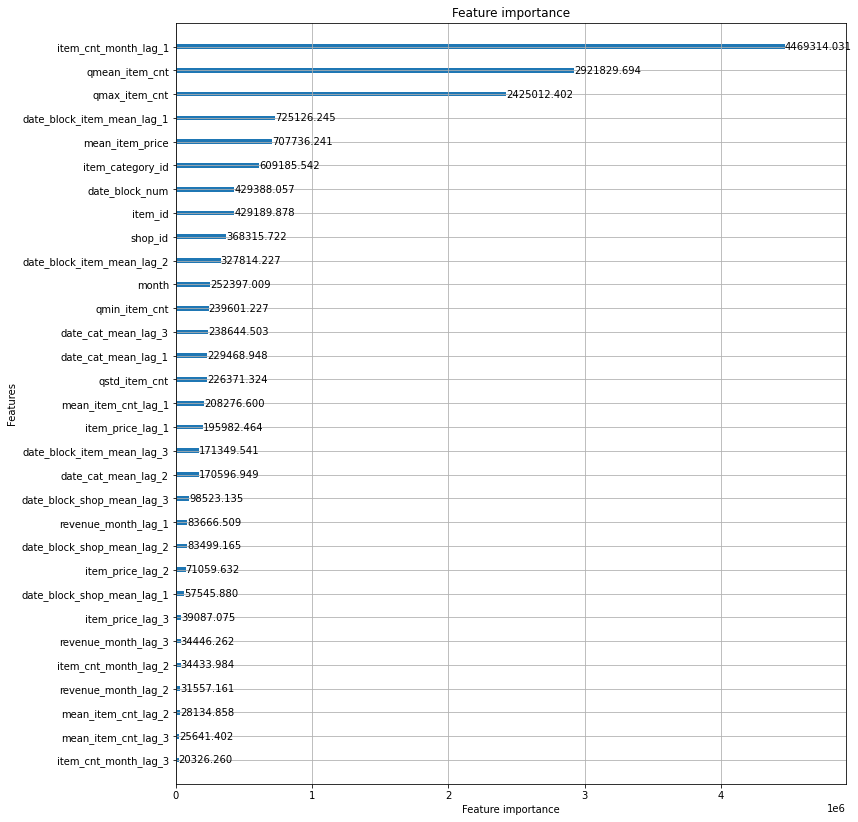

In [52]:
lgb.plot_importance(
    lgb_grid_4, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,14)) 

## Ensemble Model

In [17]:
with open('D:/Case Study/Predict future sales/lgb_grid_2b','rb') as loc:
    gbm = pickle.load(loc) 
with open('D:/Case Study/Predict future sales/best_xgb_2','rb') as loc:
    best_xgb_2 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_xgb_1','rb') as loc:
    best_xgb_1 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_rf','rb') as loc:
    best_rf = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_dt','rb') as loc:
    best_dt = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_ridge','rb') as loc:
    best_ridge = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_lasso','rb') as loc:
    best_lasso = pickle.load(loc)
    
lightgbm = lgb.LGBMRegressor()
params = gbm.params
del params['metric']
del params['early_stopping_round']
params['num_iterations'] = 500
lightgbm.set_params(**params)

LGBMRegressor(bagging_fraction=1.0, bagging_freq=0,
              categorical_column=[1, 2, 4], feature_fraction=0.8999999999999999,
              feature_pre_filter=False, force_row_wise=True,
              lambda_l1=0.00215967219985889, lambda_l2=4.585962053091403,
              num_iterations=500, num_leaves=75, seed=1, verbose=1)

In [8]:
estimators = [('lgb',lightgbm),('xgb_1',best_xgb_1), ('xgb_2',best_xgb_2), ('rf',best_rf), ('dt',best_dt), ('ridge',best_ridge), ('lasso',best_lasso)]
cv = TimeSeriesSplit(n_splits=2).get_n_splits(X_train,y_train)
ensemble = StackingRegressor(estimators, cv=cv, final_estimator=lightgbm , verbose=1)

In [9]:
ensemble.fit(X_train,y_train)
with open('D:/Case Study/Predict future sales/ensemble','wb') as loc:
    pickle.dump(ensemble,loc)

[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.585962053091403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.585962053091403
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 w

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.585962053091403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.585962053091403
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 w

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[02:19:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[04:01:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "verbose" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 192.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[05:32:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cosample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:19:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "cosample_bytree" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 206.3min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 47.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.4min finished


[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.585962053091403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.585962053091403
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lam

StackingRegressor(cv=2,
                  estimators=[('lgb',
                               LGBMRegressor(bagging_fraction=1.0,
                                             bagging_freq=0,
                                             categorical_column=[1, 2, 4],
                                             feature_fraction=0.8999999999999999,
                                             feature_pre_filter=False,
                                             force_row_wise=True,
                                             lambda_l1=0.00215967219985889,
                                             lambda_l2=4.585962053091403,
                                             num_iterations=500, num_leaves=75,
                                             seed=1, verbose=1)),
                              ('xgb_1',
                               XGBRegressor(base_score=0.5, boo...
                              ('ridge', Ridge(alpha=1e-10)),
                              ('lasso', Lasso(alpha=

In [18]:
estimators = [('lgb',lightgbm),('xgb_1',best_xgb_1), ('xgb_2',best_xgb_2), ('rf',best_rf), ('dt',best_dt), ('ridge',best_ridge), ('lasso',best_lasso)]
cv = TimeSeriesSplit(n_splits=2).get_n_splits(X_train,y_train)
ensemble2 = StackingRegressor(estimators, cv=cv, verbose=1)

In [ ]:
ensemble2.fit(X_train,y_train)
with open('D:/Case Study/Predict future sales/ensemble2','wb') as loc:
    pickle.dump(ensemble2,loc)

[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=4.585962053091403, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.585962053091403
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.8999999999999999, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8999999999999999
[LightGBM] [Warning] lambda_l1 is set=0.00215967219985889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00215967219985889
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 w

# Summary

In [16]:
with open('D:/Case Study/Predict future sales/best_lasso','rb') as loc:
    best_lasso = pickle.load(loc)
with open('D:/Case Study/Predict future sales/lasso_log','rb') as loc:
    lasso_log = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_ridge','rb') as loc:
    best_ridge = pickle.load(loc)
with open('D:/Case Study/Predict future sales/ridge_log','rb') as loc:
    ridge_log = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_dt','rb') as loc:
    best_dt = pickle.load(loc)
with open('D:/Case Study/Predict future sales/dt_log','rb') as loc:
    dt_log = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_rf','rb') as loc:
    best_rf = pickle.load(loc)
with open('D:/Case Study/Predict future sales/rf_log','rb') as loc:
    rf_log = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_xgb_1','rb') as loc:
    best_xgb_1 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/xgb_log_1','rb') as loc:
    xgb_log_1 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/best_xgb_2','rb') as loc:
    best_xgb_2 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/xgb_log_2','rb') as loc:
    xgb_log_2 = pickle.load(loc)
with open('D:/Case Study/Predict future sales/lgb_grid_2b','rb') as loc:
    lgb_grid = pickle.load(loc)
with open('D:/Case Study/Predict future sales/ensemble','rb') as loc:
    ensemble = pickle.load(loc)
    
lgb_train_rmse = mean_squared_error(lgb_grid.predict(X_train).clip(0,20),y_train, squared = False)
lgb_test_rmse = mean_squared_error(lgb_grid.predict(X_val).clip(0,20),y_val, squared = False)

ensemble_train = mean_squared_error(ensemble.predict(X_train).clip(0,20),y_train, squared=False)
ensemble_val = mean_squared_error(ensemble.predict(X_val).clip(0,20),y_val, squared=False)

x = PrettyTable()
x.field_names = ["Model", "train_rmse" , "val_rmse"]
x.add_row(["Lasso Regression", round(lasso_log[0][np.argmin(lasso_log[1])],5), round(min(lasso_log[1]),5)])
x.add_row(["Ridge Regression", round(ridge_log[0][np.argmin(ridge_log[1])],5), round(min(ridge_log[1]),5)])
x.add_row(["Decision tree Regressor", round(dt_log[0][np.argmin(dt_log[1])],5), round(min(dt_log[1]),5)])
x.add_row(["Random Forest Regressor", round(rf_log[0][np.argmin(rf_log[1])],5), round(min(rf_log[1]),5)])
x.add_row(["XGB Regressor 1", round(xgb_log_1[0][np.argmin(xgb_log_1[1])],5), round(min(xgb_log_1[1]),5)])
x.add_row(["XGB Regressor 2", round(xgb_log_2[0][np.argmin(xgb_log_2[1])],5), round(min(xgb_log_2[1]),5)])
x.add_row(["LightGBM", round(lgb_train_rmse,5), round(lgb_test_rmse,5)])
x.add_row(["Ensemble_stacking", round(ensemble_train,5), round(ensemble_val,5)])
print(x)

+-------------------------+------------+----------+
|          Model          | train_rmse | val_rmse |
+-------------------------+------------+----------+
|     Lasso Regression    |  0.77688   |  0.896   |
|     Ridge Regression    |  0.77689   |  0.896   |
| Decision tree Regressor |  0.74485   | 0.90008  |
| Random Forest Regressor |  0.73291   | 0.88755  |
|     XGB Regressor 1     |  0.68391   | 0.87192  |
|     XGB Regressor 2     |  0.70248   | 0.87285  |
|         LightGBM        |  0.64502   | 0.86073  |
|    Ensemble_stacking    |  0.64698   | 0.87851  |
+-------------------------+------------+----------+


# Final Submission

In [15]:
with open('D:/Case Study/Predict future sales/lgb_grid_2b','rb') as loc:
    gbm =  pickle.load(loc) 
    
pred_clip = gbm.predict(X_test).clip(0,20)
pred_1 = test.drop(['shop_id','item_id'],axis=1)
pred_1['item_cnt_month'] = pred_clip
pred_1.to_csv('D:/Case Study/Predict future sales/predict_ensemble',index=False)